In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from verstack import NaNImputer 
import numpy as np 
from sklearn.metrics import confusion_matrix

In [12]:
df=pd.read_csv('E:\ArcGIS\ACI Center\Data analysis\SparePartsSales_1Year.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584619 entries, 0 to 1584618
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   PageNo              1584619 non-null  int64 
 1   SL                  1584619 non-null  int64 
 2   Invoice_Id          1584619 non-null  int64 
 3   InvoiceNo           1584619 non-null  object
 4   Invoice_Date        1584619 non-null  object
 5   Dealer_Code         1584619 non-null  object
 6   Dealer_Name         1584619 non-null  object
 7   Customer_Type       1584619 non-null  object
 8   Customer_Name       1584587 non-null  object
 9   Address             137601 non-null   object
 10  Mobile              789701 non-null   object
 11  Job_Card_No         1584619 non-null  object
 12  Job_Type            1133725 non-null  object
 13  Job_Type_Details    295331 non-null   object
 14  Product_Code        1584619 non-null  object
 15  Product_Name        1584619 non-

In [13]:
# Filter rows where Selling Price and Discount are not negative
clean_df = df[(df['SellingPrice'] >= 0) & (df['Discount'] >= 0)]

clean_df.info()
df=clean_df


<class 'pandas.core.frame.DataFrame'>
Index: 1584388 entries, 0 to 1584618
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   PageNo              1584388 non-null  int64 
 1   SL                  1584388 non-null  int64 
 2   Invoice_Id          1584388 non-null  int64 
 3   InvoiceNo           1584388 non-null  object
 4   Invoice_Date        1584388 non-null  object
 5   Dealer_Code         1584388 non-null  object
 6   Dealer_Name         1584388 non-null  object
 7   Customer_Type       1584388 non-null  object
 8   Customer_Name       1584358 non-null  object
 9   Address             137565 non-null   object
 10  Mobile              789574 non-null   object
 11  Job_Card_No         1584388 non-null  object
 12  Job_Type            1133654 non-null  object
 13  Job_Type_Details    295316 non-null   object
 14  Product_Code        1584388 non-null  object
 15  Product_Name        1584388 non-null 

In [14]:
# Group by 'Product_Name' and aggregate 'Product_Code' using apply
result = df.groupby('Product_Name').apply(
    lambda group: pd.Series({
        'Product_Codes': ', '.join(group['Product_Code'].unique()),  # Join unique product codes
        'Product_Code_Count': group['Product_Code'].nunique()       # Count unique product codes
    })
).reset_index()

# Rename columns for clarity
result.columns = ['Product_Name', 'Product_Codes', 'Product_Code_Count']

# Sort the DataFrame by 'Product_Code_Count' in descending order
result_sorted = result.sort_values(by='Product_Code_Count', ascending=False).reset_index(drop=True)

# Display the sorted result
print(result_sorted)


                 Product_Name  \
0                     BEARING   
1                BOLT, FLANGE   
2                        BOLT   
3                      COLLAR   
4           TANK SIDE COVER 2   
...                       ...   
2347      COVER, HANDLE FRONT   
2348       COVER, HANDLE LEVE   
2349  ASSIST GRIP ASSY.,-MBL2   
2350      COVER, HANDLE UPPER   
2351  Yamalube Sporty Premium   

                                          Product_Codes  Product_Code_Count  
0     PE46, PW34, P241, PJ21, P243, PBKF, P244, PM73...                  59  
1     PN28, P251, P104, P171, PR22, P252, P250, Y110...                  57  
2     PBIU, P173, P229, P174, PCHO, PR37, P348, PJ13...                  39  
3     PT15, P208, P203, P205, P308, P207, P842, P200...                  33  
4     Y184, Y186, YE88, YE89, Y182, PS59, Y183, YE90...                  29  
...                                                 ...                 ...  
2347                                               Y032  

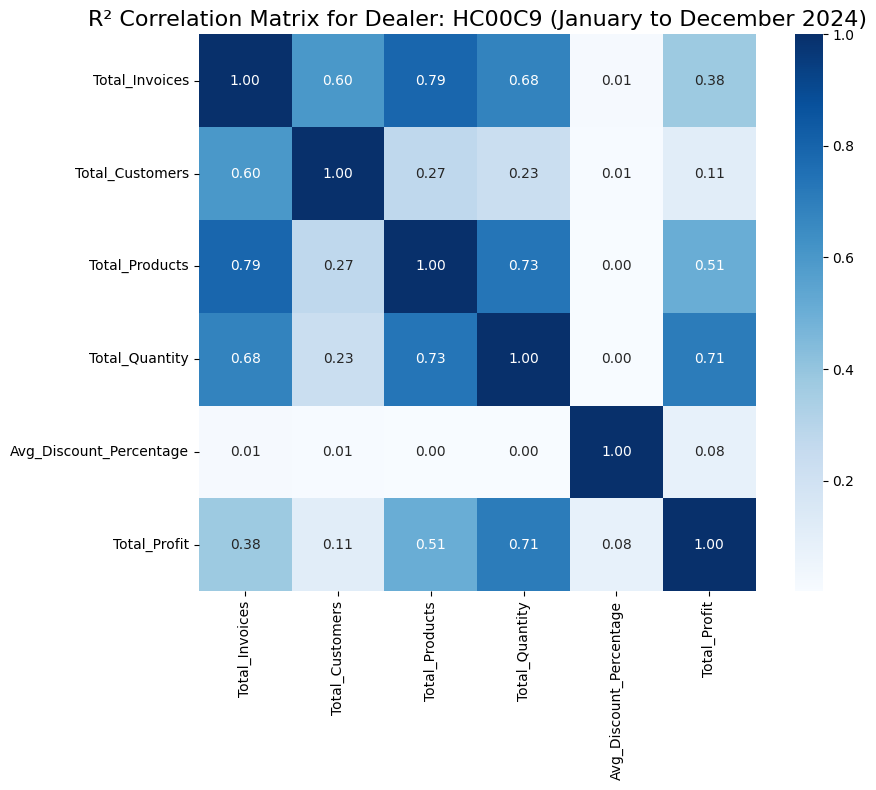

In [15]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Add a column for 7-day periods
df['7_Day_Period'] = df['Invoice_Date'].dt.to_period('7D')

# Function to calculate discount percentage
def calculate_discount_percentage(row):
    return (row['Discount'] / (row['Discount'] + row['Buying_Price'])) * 100 if (row['Discount'] + row['Buying_Price']) > 0 else 0

df['Discount_Percentage'] = df.apply(calculate_discount_percentage, axis=1)

# Function to analyze and compute correlation matrix for a specific dealer
def analyze_dealer_correlation_matrix(dealer_code):
    # Step 1: Filter data for the given dealer
    dealer_data = df[df['Dealer_Code'] == dealer_code]

    if dealer_data.empty:
        print(f"No data found for Dealer Code: {dealer_code}")
        return

    # Step 2: Aggregate data by 7-day periods
    aggregated_data = dealer_data.groupby('7_Day_Period').agg(
        Total_Invoices=('InvoiceNo', 'count'),  # Total invoice count
        Total_Customers=('Customer_Name', 'nunique'),  # Unique customer count
        Total_Products=('Product_Name', 'nunique'),  # Unique product count
        Total_Quantity=('Quantity', 'sum'),  # Total quantity
        Avg_Discount_Percentage=('Discount_Percentage', 'mean'),  # Average discount percentage
        Total_Profit=('Total_Profit', 'sum')  # Total profit summation
    ).reset_index()

    # Exclude non-numeric columns (like '7_Day_Period') from correlation computation
    numeric_data = aggregated_data.drop(columns=['7_Day_Period'])

    # Step 3: Compute correlation matrix (R² values)
    correlation_matrix = numeric_data.corr() ** 2

    # Step 4: Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', cbar=True, square=True,
                xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
    plt.title(f'R² Correlation Matrix for Dealer: {dealer_code} (January to December 2024)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Input dealer code for analysis
dealer_code_input = input("Enter Dealer Code: ")
analyze_dealer_correlation_matrix(dealer_code_input)



Rank of product according to total loss


Top 10 Products by Loss Percentage (Counter Sales):
           Product_Name  Counter_Sales_Count  Avg_Discount_Percentage  \
1638         PIN, SPLIT                   18                 0.000000   
1629        PIN, COTTER                    1                 0.000000   
22      .SCREW, FITTING                    2                 0.000000   
1640          PIN-SPLIT                    5                 0.000000   
1848  SCREW WITH WASHER                   15                 0.000000   
1947   SPLIT COTTER PIN                    7                 0.000000   
236           CAP, BOLT                   45                 0.952381   
1855    SCREW, PAN HEAD                  166                 2.086695   
52                 BALL                  147                 2.482993   
1524     OIL SEAL (RXS)                    1                 0.000000   

      Avg_Loss_Percentage  
1638           794.444444  
1629           700.000000  
22             550.000000  
1640           468.000000  
184

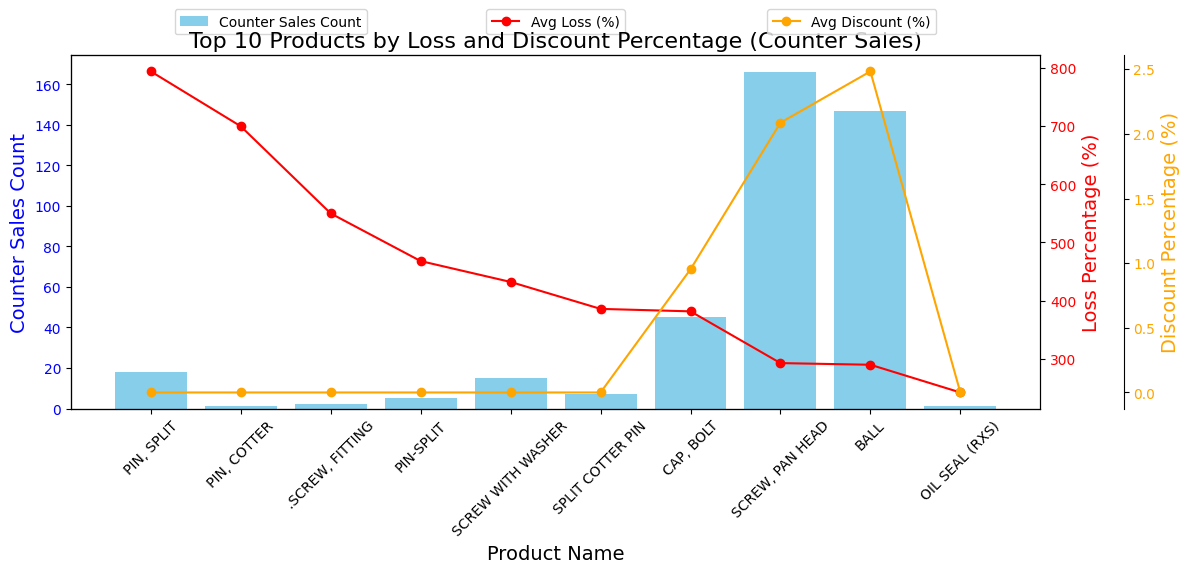

In [16]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Function to calculate discount percentage
def calculate_discount_percentage(row):
    return (row['Discount'] / (row['Discount'] + row['Buying_Price'])) * 100 if (row['Discount'] + row['Buying_Price']) > 0 else 0

# Function to calculate loss percentage
def calculate_loss_percentage(row):
    return (row['Total_Profit'] / row['Buying_Price']) * 100 if row['Buying_Price'] > 0 else 0

# Apply discount and loss percentage calculations
df['Discount_Percentage'] = df.apply(calculate_discount_percentage, axis=1)
df['Loss_Percentage'] = df.apply(calculate_loss_percentage, axis=1)

# Filter for Counter Sales
counter_sales_data = df[df['Job_Card_No'] == 'Counter Sales']

# Group by Product Name and calculate required metrics
aggregated_data = counter_sales_data.groupby('Product_Name').agg(
    Counter_Sales_Count=('Job_Card_No', 'count'),
    Avg_Discount_Percentage=('Discount_Percentage', 'mean'),
    Avg_Loss_Percentage=('Loss_Percentage', 'mean')
).reset_index()

# Sort by Average Loss Percentage (highest to lowest)
sorted_data = aggregated_data.sort_values(by='Avg_Loss_Percentage', ascending=False)

# Select the top 10 products
top_10_products = sorted_data.head(10)

# Display the top 10 results in the terminal
print("\nTop 10 Products by Loss Percentage (Counter Sales):")
print(top_10_products)

# Plot a three-axis bar chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for Counter Sales Count
ax1.bar(top_10_products['Product_Name'], top_10_products['Counter_Sales_Count'], color='skyblue', label='Counter Sales Count')
ax1.set_xlabel('Product Name', fontsize=14)
ax1.set_ylabel('Counter Sales Count', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', rotation=45)

# Secondary Y-axis for Loss Percentage
ax2 = ax1.twinx()
ax2.plot(top_10_products['Product_Name'], top_10_products['Avg_Loss_Percentage'], color='red', marker='o', label='Avg Loss (%)')
ax2.set_ylabel('Loss Percentage (%)', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Third Y-axis for Discount Percentage
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Offset the third axis
ax3.plot(top_10_products['Product_Name'], top_10_products['Avg_Discount_Percentage'], color='orange', marker='o', label='Avg Discount (%)')
ax3.set_ylabel('Discount Percentage (%)', fontsize=14, color='orange')
ax3.tick_params(axis='y', labelcolor='orange')

# Add legends for all axes
ax1.legend(loc='upper left', bbox_to_anchor=(0.1, 1.15), fontsize=10)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=10)
ax3.legend(loc='upper right', bbox_to_anchor=(0.9, 1.15), fontsize=10)

# Add a title
plt.title('Top 10 Products by Loss and Discount Percentage (Counter Sales)', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()


Processing Group 1...


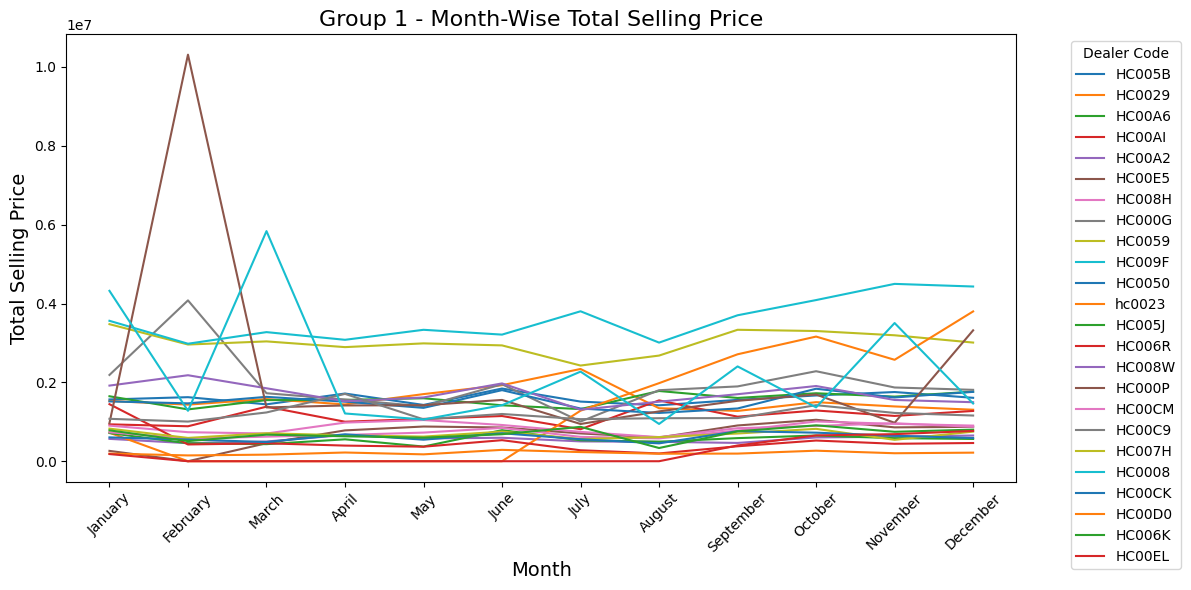

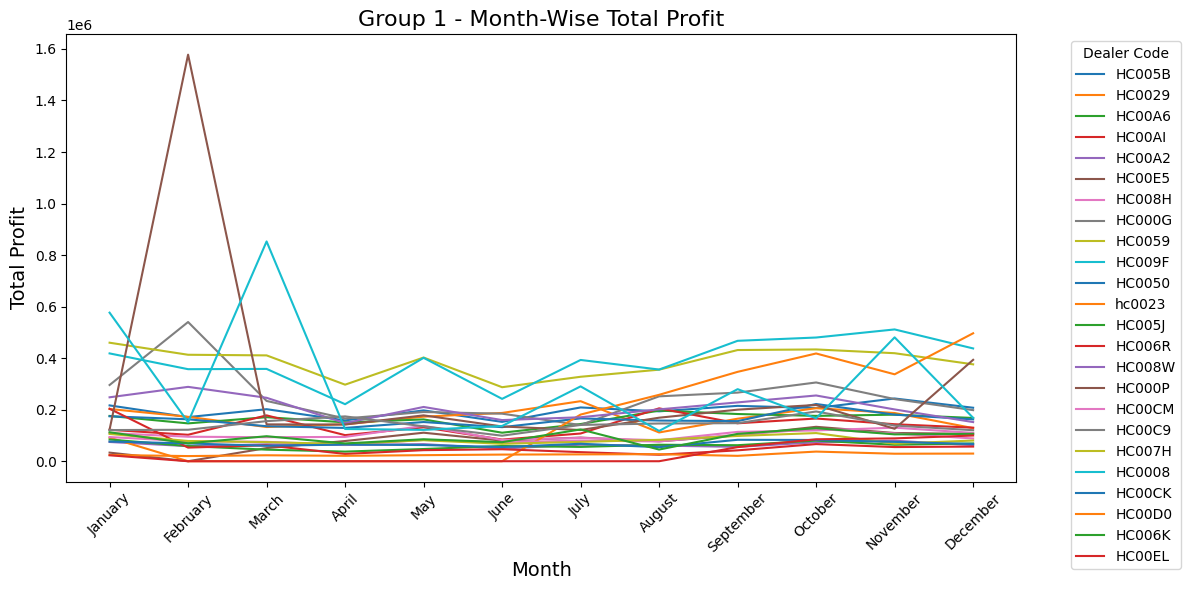

Processing Group 2...


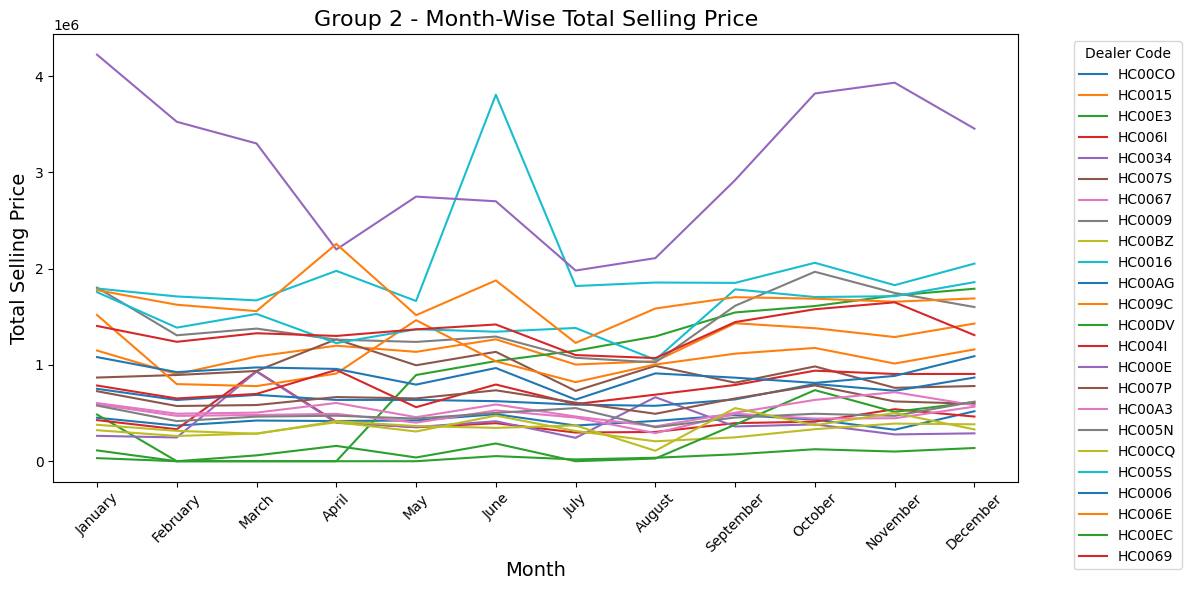

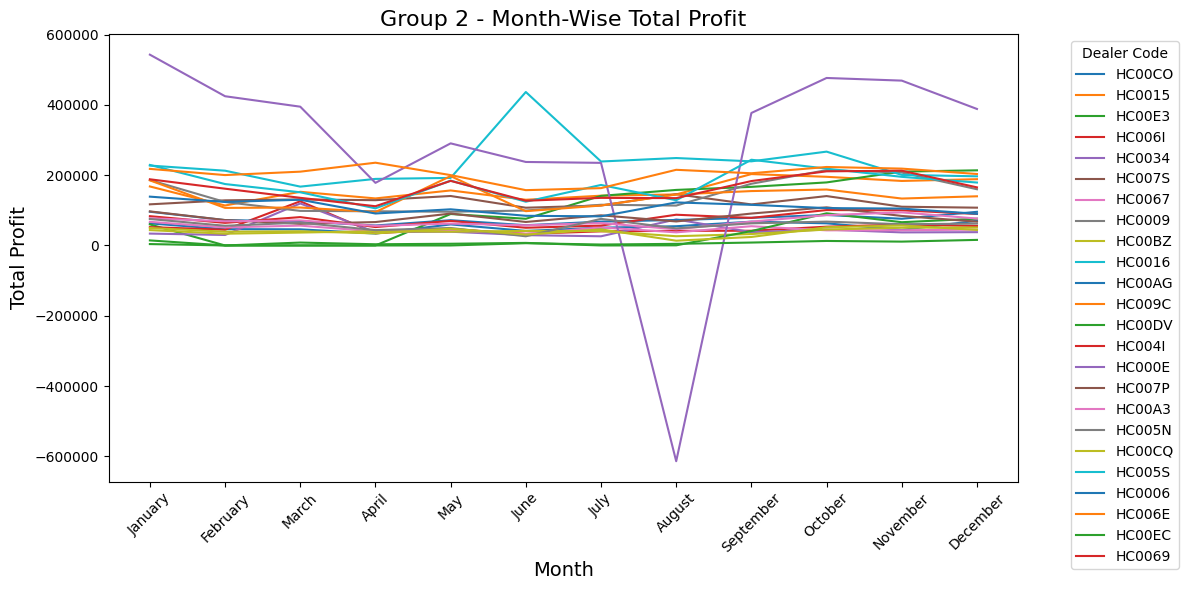

Processing Group 3...


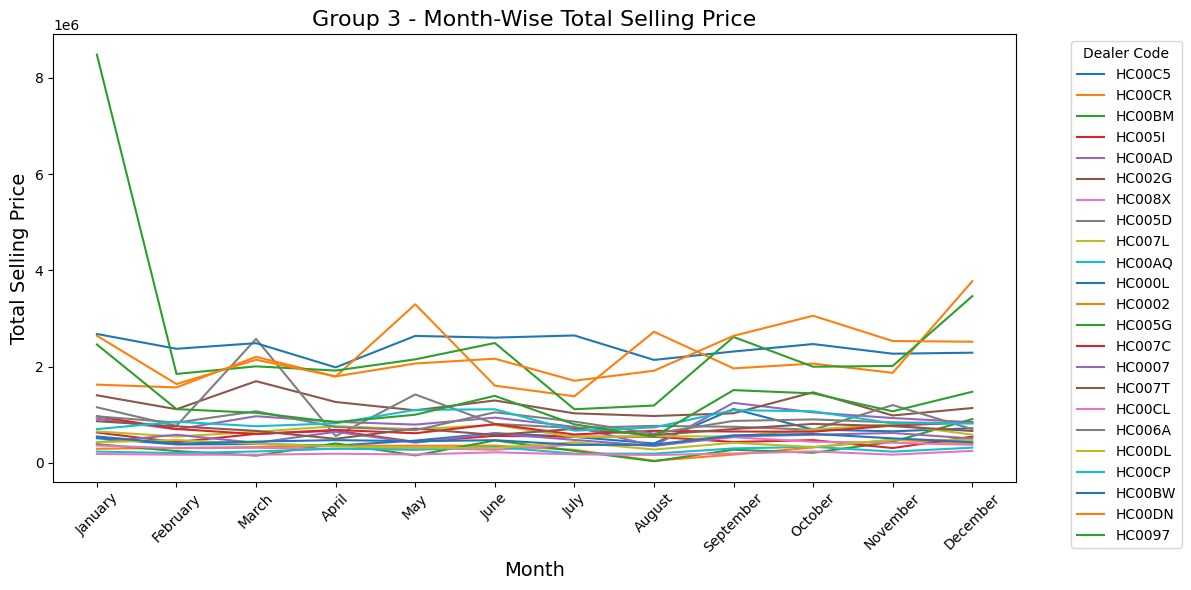

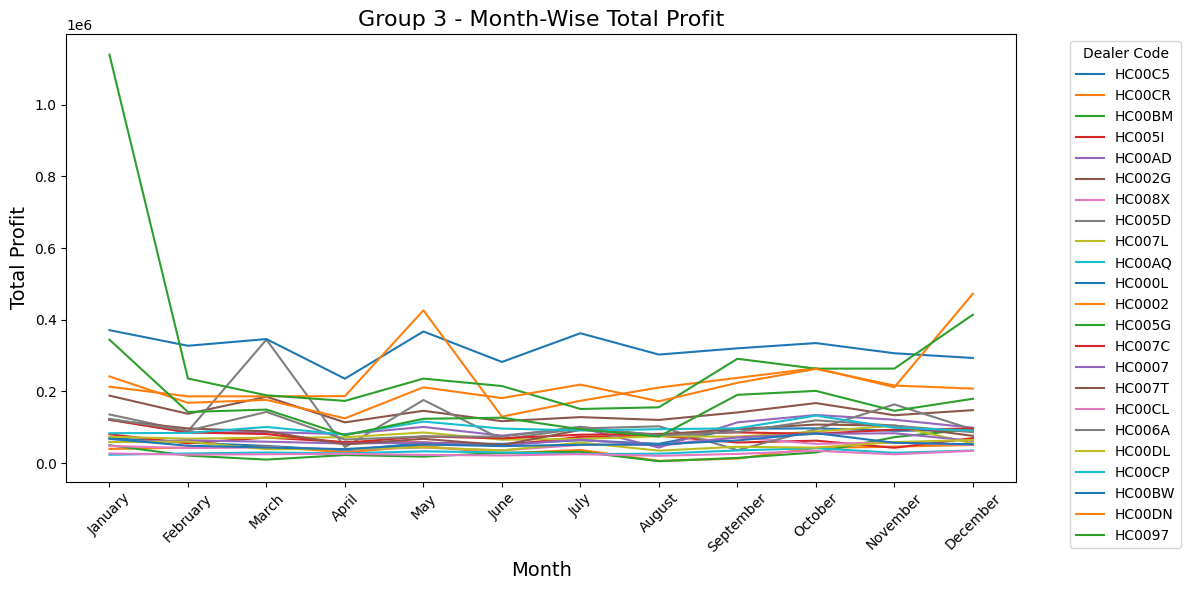

Processing Group 4...


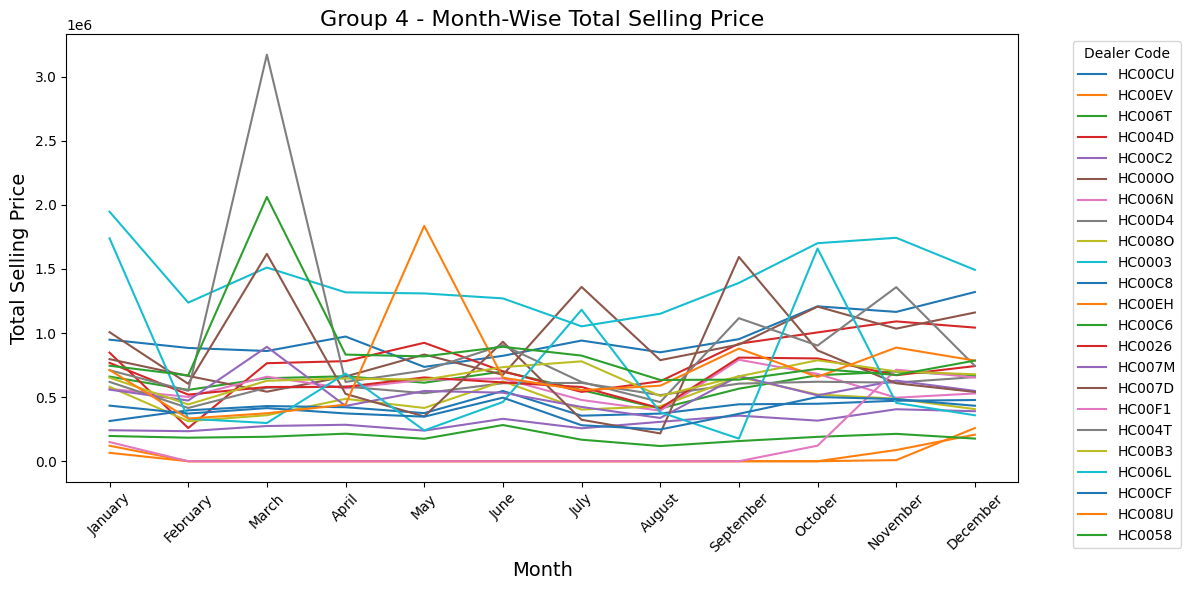

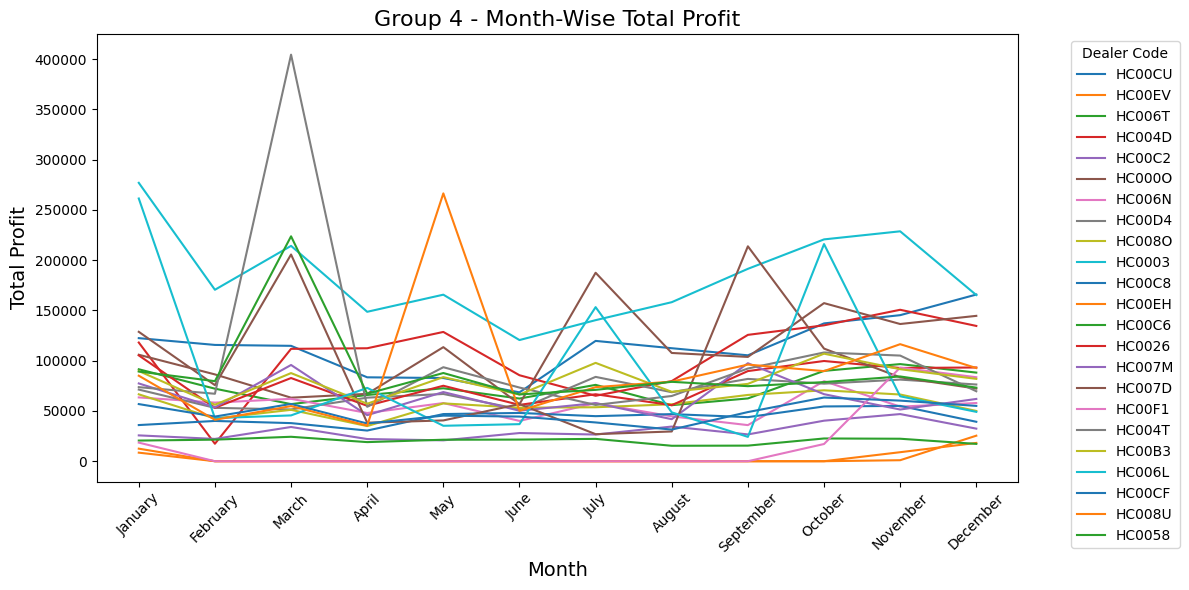

Processing Group 5...


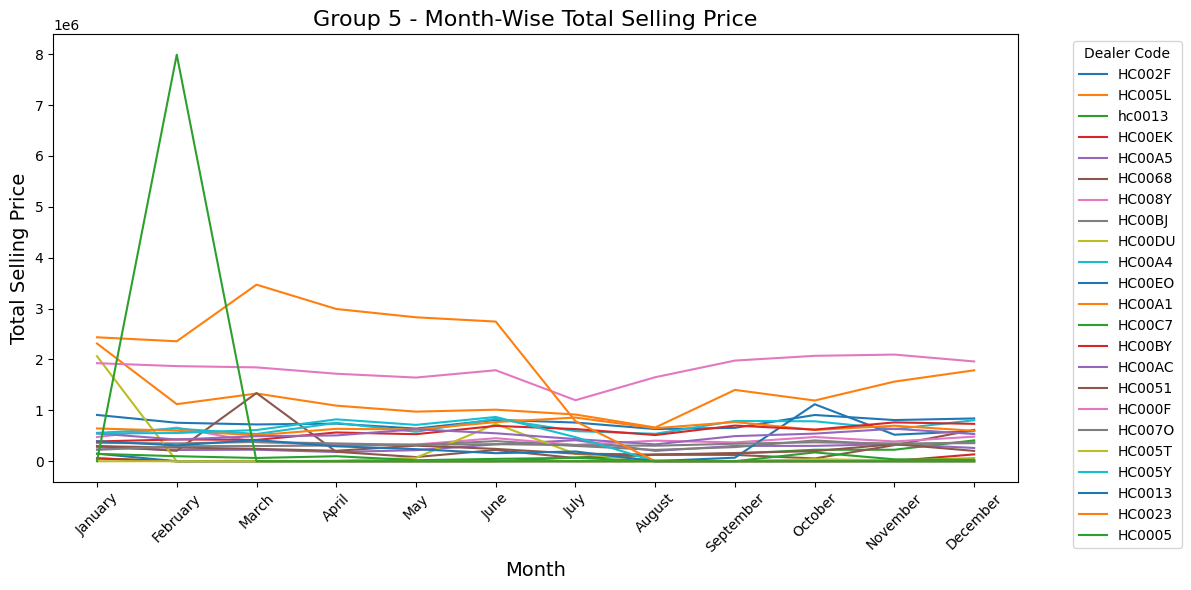

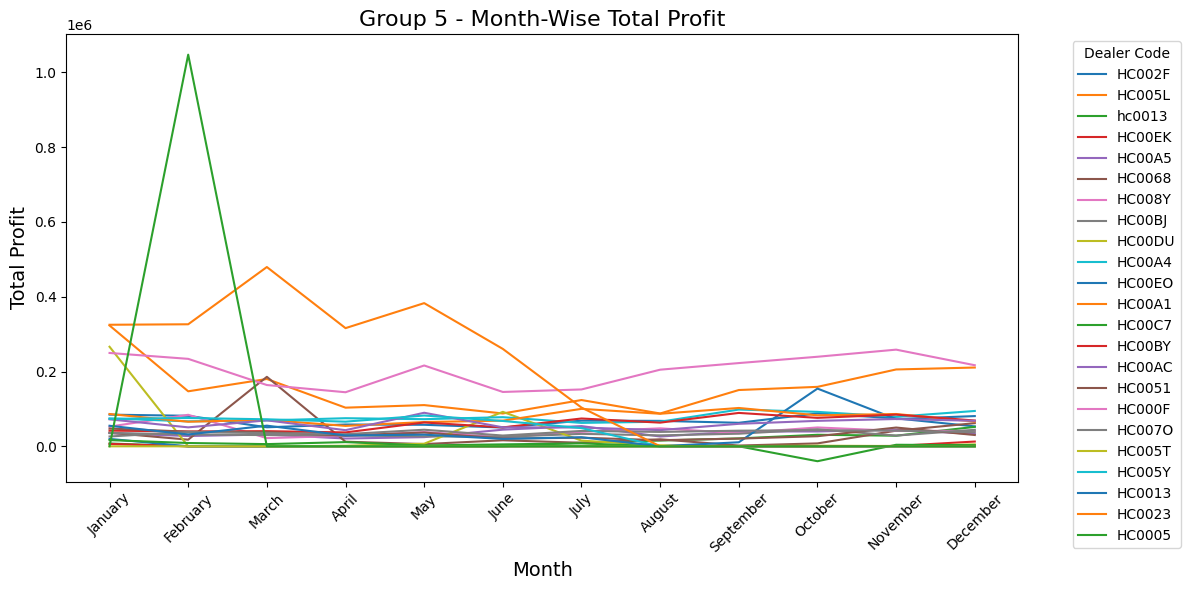

In [17]:
# Ensure Invoice_Date is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Extract month name from Invoice_Date
df['Month'] = df['Invoice_Date'].dt.strftime('%B')

# Define month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Get the unique dealer codes
dealer_codes = df['Dealer_Code'].unique()

# Divide the dealer codes into 5 groups
grouped_dealer_codes = np.array_split(dealer_codes, 5)

# Function to plot graphs for a single group
def plot_group_graphs(dealer_group, group_number):
    # Filter data for the dealers in this group
    group_data = df[df['Dealer_Code'].isin(dealer_group)]

    # Calculate total selling price and profit by month for each dealer
    selling_price_data = group_data.groupby(['Dealer_Code', 'Month'])['SellingPriceTotal'].sum().reset_index()
    profit_data = group_data.groupby(['Dealer_Code', 'Month'])['Total_Profit'].sum().reset_index()

    # Plot total selling price graph
    plt.figure(figsize=(12, 6))
    for dealer_code in dealer_group:
        dealer_selling_data = selling_price_data[selling_price_data['Dealer_Code'] == dealer_code]
        plt.plot(dealer_selling_data['Month'], dealer_selling_data['SellingPriceTotal'], label=dealer_code)
    plt.title(f'Group {group_number} - Month-Wise Total Selling Price', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Total Selling Price', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Dealer Code', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot total profit graph
    plt.figure(figsize=(12, 6))
    for dealer_code in dealer_group:
        dealer_profit_data = profit_data[profit_data['Dealer_Code'] == dealer_code]
        plt.plot(dealer_profit_data['Month'], dealer_profit_data['Total_Profit'], label=dealer_code)
    plt.title(f'Group {group_number} - Month-Wise Total Profit', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Total Profit', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Dealer Code', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Loop through each group and plot graphs
for group_number, dealer_group in enumerate(grouped_dealer_codes, start=1):
    print(f"Processing Group {group_number}...")
    plot_group_graphs(dealer_group, group_number)



Month-Wise Loss Percentage Comparison (With and Without Discount Condition)

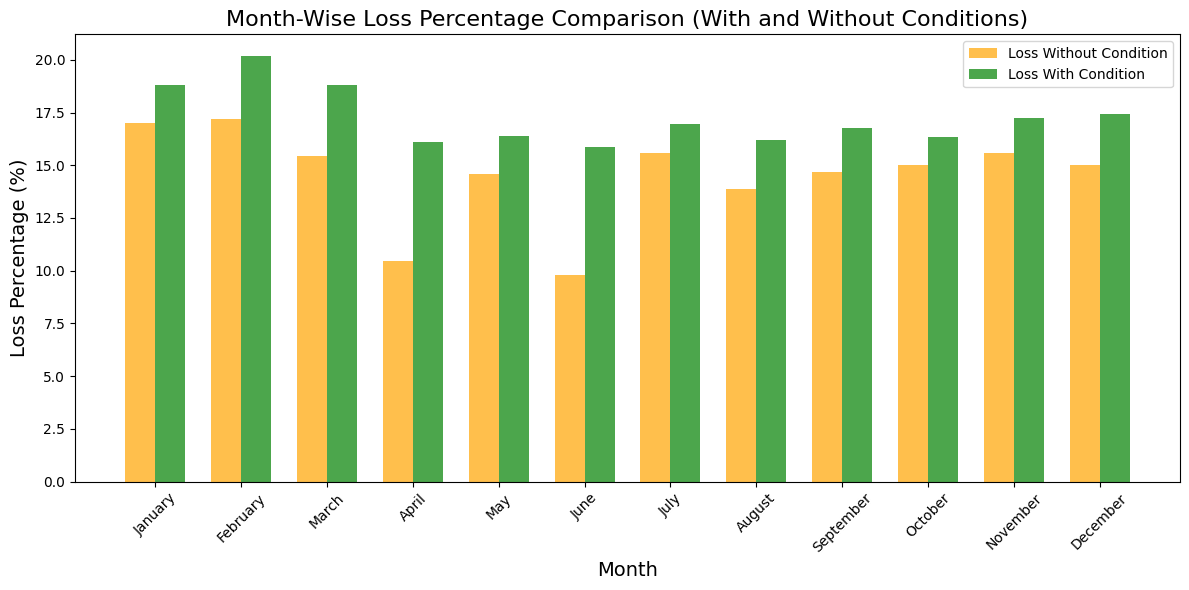


Month-Wise Loss Percentage Comparison:
        Month  Loss_Without_Condition  Loss_With_Condition
0     January               17.024380            18.822934
1    February               17.183161            20.197810
2       March               15.423314            18.782306
3       April               10.467278            16.081037
4         May               14.605973            16.380250
5        June                9.817687            15.871713
6        July               15.584264            16.953494
7      August               13.859868            16.219899
8   September               14.679249            16.760261
9     October               15.003828            16.353650
10   November               15.564405            17.260362
11   December               15.017254            17.447038


In [18]:
# Ensure Invoice_Date is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Extract month names
df['Month'] = df['Invoice_Date'].dt.strftime('%B')

# Define the month order for sorting
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Calculate discount percentage
def calculate_discount_percentage(row):
    return (row['Discount'] / (row['Discount'] + row['Buying_Price'])) * 100 if (row['Discount'] + row['Buying_Price']) > 0 else 0

# Calculate loss percentage
def calculate_loss_percentage(row):
    return (row['Total_Profit'] / row['Buying_Price']) * 100 if row['Buying_Price'] > 0 else 0

# Apply calculations
df['Discount_Percentage'] = df.apply(calculate_discount_percentage, axis=1)
df['Loss_Percentage'] = df.apply(calculate_loss_percentage, axis=1)

# Month-wise analysis
results = []

for month in month_order:
    # Filter data for the current month
    month_data = df[df['Month'] == month]
    
    if month_data.empty:
        continue

    # Total loss percentage without condition
    total_loss_without_condition = (month_data['Total_Profit'].sum() / month_data['Buying_Price'].sum()) * 100

    # Apply Condition 1: Exclude products with an average discount percentage above 5%
    condition_1_data = month_data[month_data['Discount_Percentage'] <= 5]

    # Total loss percentage with condition
    total_loss_with_condition = (condition_1_data['Total_Profit'].sum() / condition_1_data['Buying_Price'].sum()) * 100 if not condition_1_data.empty else 0

    # Store results
    results.append({
        'Month': month,
        'Loss_Without_Condition': total_loss_without_condition,
        'Loss_With_Condition': total_loss_with_condition
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the comparison
x = np.arange(len(results_df['Month']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Bar for Loss Without Condition
rects1 = ax.bar(x - width/2, results_df['Loss_Without_Condition'], width, label='Loss Without Condition', color='orange', alpha=0.7)

# Bar for Loss With Condition
rects2 = ax.bar(x + width/2, results_df['Loss_With_Condition'], width, label='Loss With Condition', color='green', alpha=0.7)

# Add titles and labels
ax.set_title('Month-Wise Loss Percentage Comparison (With and Without Conditions)', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Loss Percentage (%)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(results_df['Month'], rotation=45)
ax.legend()

# Layout adjustments
plt.tight_layout()

# Show the plot
plt.show()

# Print results in the terminal
print("\nMonth-Wise Loss Percentage Comparison:")
print(results_df)


Month-Wise Reduction in Loss Percentage After Applying Discount Condition

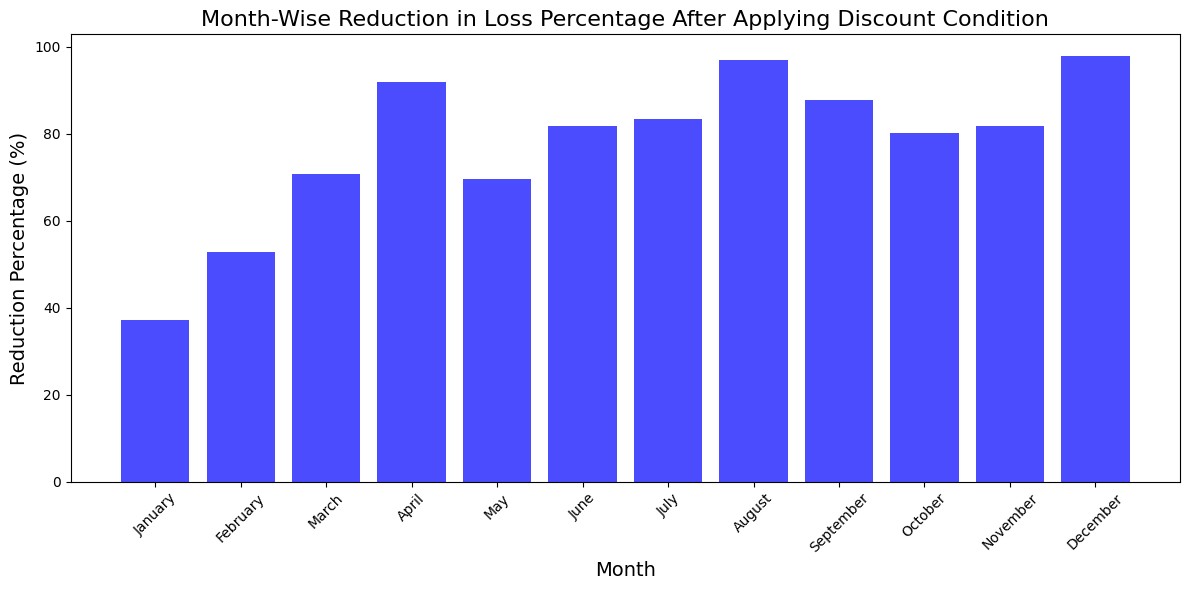


Month-Wise Reduction Percentage:
        Month  Reduction_Percentage
0     January             37.089806
1    February             52.723889
2       March             70.782239
3       April             91.877960
4         May             69.577027
5        June             81.906031
6        July             83.497936
7      August             96.901070
8   September             87.687098
9     October             80.144691
10   November             81.704548
11   December             97.989561


In [19]:
# Ensure Invoice_Date is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Extract month names
df['Month'] = df['Invoice_Date'].dt.strftime('%B')

# Define the month order for sorting
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Calculate discount percentage
def calculate_discount_percentage(row):
    return (row['Discount'] / (row['Discount'] + row['Buying_Price'])) * 100 if (row['Discount'] + row['Buying_Price']) > 0 else 0

# Apply calculations
df['Discount_Percentage'] = df.apply(calculate_discount_percentage, axis=1)

# Initialize results
results = []

# Loop through each month
for month in month_order:
    # Filter data for the current month
    month_data = df[df['Month'] == month]
    
    if month_data.empty:
        continue

    # Calculate Loss 1 (Without Condition)
    month_data['Loss'] = month_data['SellingPrice'] - month_data['Buying_Price']
    loss_1 = month_data[month_data['Loss'] < 0]['Loss'].sum()

    # Apply the discount condition (Exclude Discount > 5%)
    conditioned_data = month_data[month_data['Discount_Percentage'] <= 5]

    # Calculate Loss 2 (With Condition)
    loss_2 = conditioned_data[conditioned_data['Loss'] < 0]['Loss'].sum()

    # Calculate Reduction Percentage
    if loss_1 != 0:
        reduction_percentage = ((loss_1 - loss_2) / loss_1) * 100
    else:
        reduction_percentage = 0

    # Store results
    results.append({
        'Month': month,
        'Reduction_Percentage': reduction_percentage
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the reduction percentage
plt.figure(figsize=(12, 6))
plt.bar(results_df['Month'], results_df['Reduction_Percentage'], color='blue', alpha=0.7)
plt.title('Month-Wise Reduction in Loss Percentage After Applying Discount Condition', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Reduction Percentage (%)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print results in the terminal
print("\nMonth-Wise Reduction Percentage:")
print(results_df)


Month-wise Counter Sales Loss as Percentage of Total Loss

        Month  Total_Loss  Counter_Sales_Loss  Counter_Sales_Loss_Percentage
4     January    -1203576             -625139                      51.940135
3    February    -1394844             -524447                      37.598972
7       March    -1145519             -419974                      36.662334
0       April    -1647628             -489245                      29.693899
8         May     -653493             -410290                      62.784146
6        June    -1712029             -756690                      44.198434
5        July     -320469             -202700                      63.251048
1      August     -855521             -805592                      94.163907
11  September     -523589             -205482                      39.244904
10    October     -470242             -241639                      51.386095
9    November     -326808             -149603                      45.777031
2    December     -153648              -93220                      60.671144

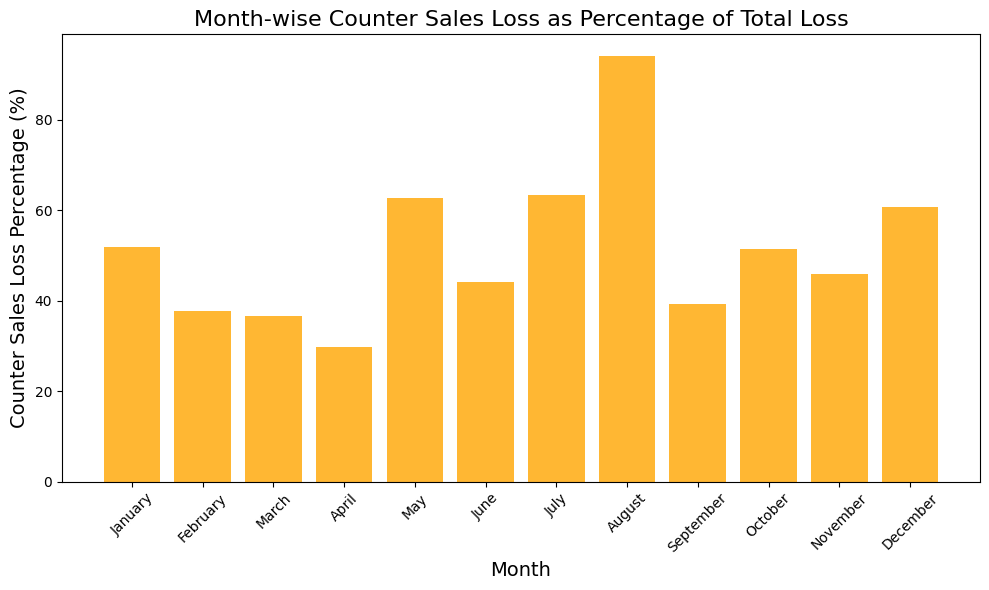

In [20]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Extract month names
df['Month'] = df['Invoice_Date'].dt.strftime('%B')

# Filter rows where Job_Card_No is "Counter Sales"
counter_sales_data = df[df['Job_Card_No'].str.strip() == 'Counter Sales']

# Define a function to calculate loss (only consider negative values as loss)
def calculate_loss(row):
    loss = row['SellingPrice'] - row['Buying_Price']
    return loss if loss < 0 else 0

# Apply the loss calculation to the entire DataFrame
df['Loss'] = df.apply(calculate_loss, axis=1)
counter_sales_data['Loss'] = counter_sales_data.apply(calculate_loss, axis=1)

# Group by Month and calculate total loss
total_loss_per_month = df.groupby('Month')['Loss'].sum().reset_index(name='Total_Loss')
counter_sales_loss_per_month = counter_sales_data.groupby('Month')['Loss'].sum().reset_index(name='Counter_Sales_Loss')

# Merge the two datasets on Month
merged_loss_data = pd.merge(total_loss_per_month, counter_sales_loss_per_month, on='Month', how='left')
merged_loss_data['Counter_Sales_Loss_Percentage'] = (
    (merged_loss_data['Counter_Sales_Loss'] / merged_loss_data['Total_Loss']) * 100
).fillna(0)  # Fill NaN with 0 for months without "Counter Sales" losses

# Sort by Month for better presentation
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
merged_loss_data['Month'] = pd.Categorical(merged_loss_data['Month'], categories=month_order, ordered=True)
merged_loss_data = merged_loss_data.sort_values('Month')

# Display the result
print(merged_loss_data)

# Plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(merged_loss_data['Month'], merged_loss_data['Counter_Sales_Loss_Percentage'], color='orange', alpha=0.8)
plt.title('Month-wise Counter Sales Loss as Percentage of Total Loss', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Counter Sales Loss Percentage (%)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Month-Wise Analysis: Counter Sales Loss and Rows Percentage

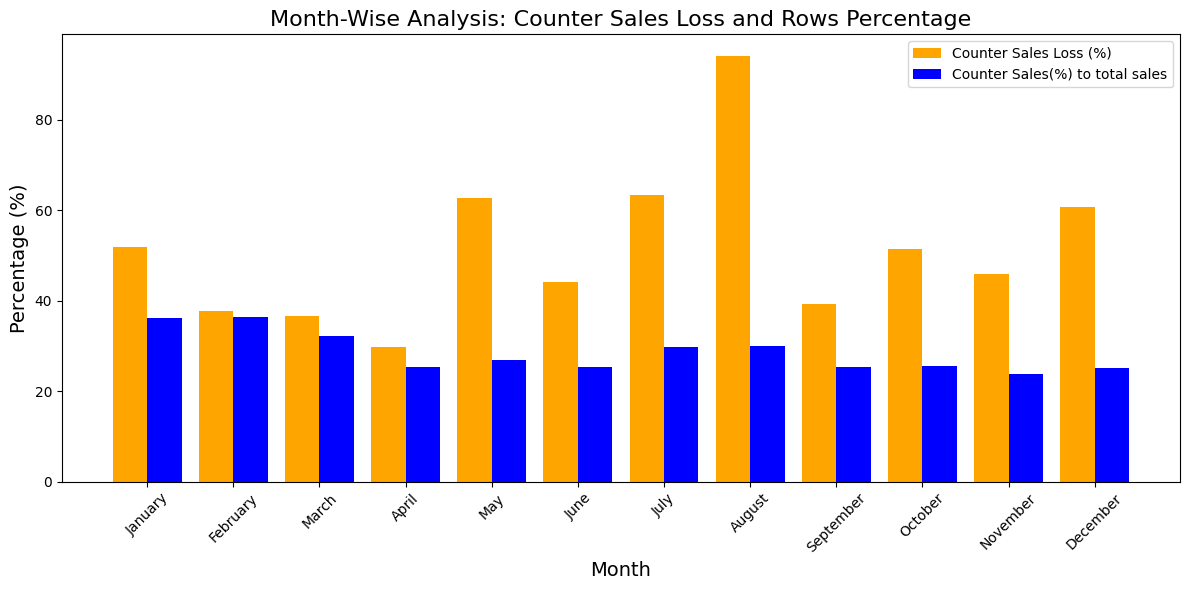

In [21]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Extract the month name
df['Month'] = df['Invoice_Date'].dt.strftime('%B')

# Define the month order for sorting
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Calculate loss for all rows
df['Loss'] = df['SellingPrice'] - df['Buying_Price']
df['Loss'] = df['Loss'].apply(lambda x: x if x < 0 else 0)  # Only negative values are considered as loss

# Filter "Counter Sales" rows
counter_sales_df = df[df['Job_Card_No'] == 'Counter Sales']

# Month-wise calculations
results = []
for month in month_order:
    # Filter data for the current month
    month_data = df[df['Month'] == month]
    counter_sales_data = counter_sales_df[counter_sales_df['Month'] == month]
    
    if month_data.empty:
        continue

    # Total loss and Counter Sales loss
    total_loss = month_data['Loss'].sum()
    counter_sales_loss = counter_sales_data['Loss'].sum()

    # Total row count and Counter Sales row count
    total_rows = len(month_data)
    counter_sales_rows = len(counter_sales_data)

    # Calculate percentages
    loss_percentage = (counter_sales_loss / total_loss) * 100 if total_loss != 0 else 0
    row_percentage = (counter_sales_rows / total_rows) * 100 if total_rows != 0 else 0

    # Append results
    results.append({
        'Month': month,
        'Counter_Sales_Loss_Percentage': loss_percentage,
        'Counter_Sales_Row_Percentage': row_percentage
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the side-by-side bar chart
x = range(len(results_df))
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x, results_df['Counter_Sales_Loss_Percentage'], width=width, label='Counter Sales Loss (%)', color='orange')
plt.bar([i + width for i in x], results_df['Counter_Sales_Row_Percentage'], width=width, label='Counter Sales(%) to total sales', color='blue')
plt.xticks([i + width / 2 for i in x], results_df['Month'], rotation=45)
plt.title('Month-Wise Analysis: Counter Sales Loss and Rows Percentage', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

Top 10 Product Names Contributing profit or loss to the all rows of counter sales

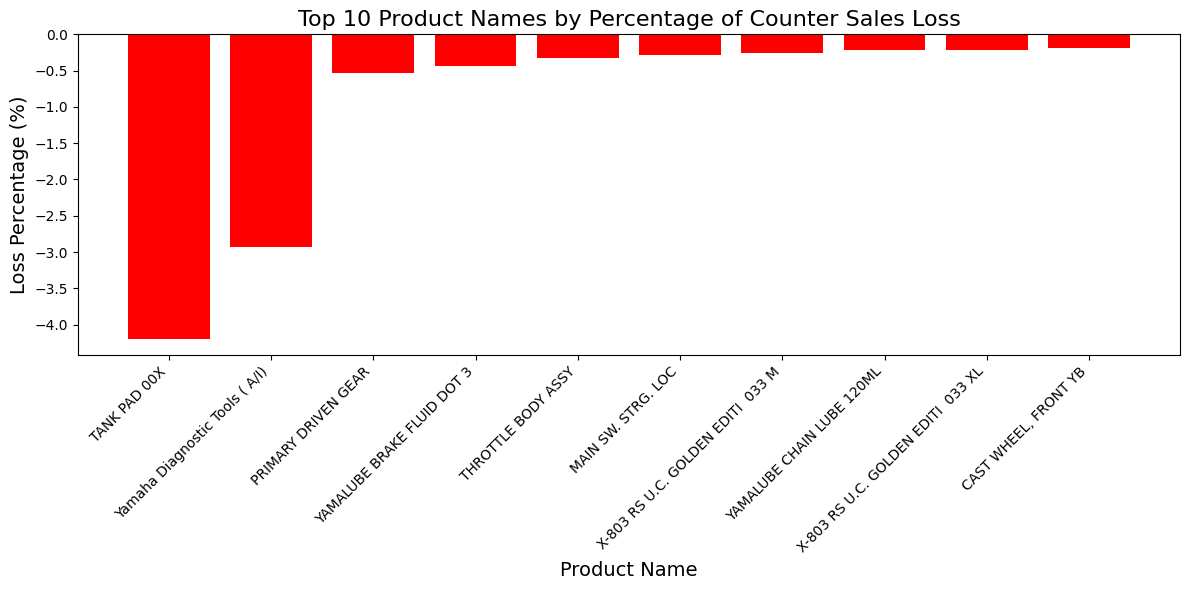


Top 10 Product Names Contributing to Counter Sales Loss (Percentage):
                            Product_Name  Profit_Percentage
2050                        TANK PAD 00X          -4.201536
2219      Yamaha Diagnostic Tools ( A/I)          -2.929765
1725                 PRIMARY DRIVEN GEAR          -0.530335
2201          YAMALUBE BRAKE FLUID DOT 3          -0.436419
2101                  THROTTLE BODY ASSY          -0.323425
1008                  MAIN SW. STRG. LOC          -0.284708
2194   X-803 RS U.C. GOLDEN EDITI  033 M          -0.251690
2205           YAMALUBE CHAIN LUBE 120ML          -0.215451
2195  X-803 RS U.C. GOLDEN EDITI  033 XL          -0.211311
263                 CAST WHEEL, FRONT YB          -0.184599


In [22]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Calculate profit (or loss) for all rows
df['Profit'] = df['SellingPrice'] - df['Buying_Price']

# Filter only rows with "Counter Sales"
counter_sales_df = df[df['Job_Card_No'] == 'Counter Sales']

# Group by Product_Name and calculate total profit for Counter Sales
product_profit = counter_sales_df.groupby('Product_Name')['Profit'].sum().reset_index()

# Calculate the percentage contribution of each product's profit to the total profit
total_profit = product_profit['Profit'].sum()
product_profit['Profit_Percentage'] = (product_profit['Profit'] / total_profit) * 100

# Sort by profit percentage (ascending to show maximum loss products first)
top_loss_products = product_profit.sort_values('Profit_Percentage').head(10)

# Plot the top 10 products with maximum loss
plt.figure(figsize=(12, 6))
plt.bar(top_loss_products['Product_Name'], top_loss_products['Profit_Percentage'], color='red')
plt.title('Top 10 Product Names by Percentage of Counter Sales Loss', fontsize=16)
plt.xlabel('Product Name', fontsize=14)
plt.ylabel('Loss Percentage (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the results in the terminal
print("\nTop 10 Product Names Contributing to Counter Sales Loss (Percentage):")
print(top_loss_products[['Product_Name', 'Profit_Percentage']])

Per invoice loss of coutner sales and non counter sales product ( top 10 products)

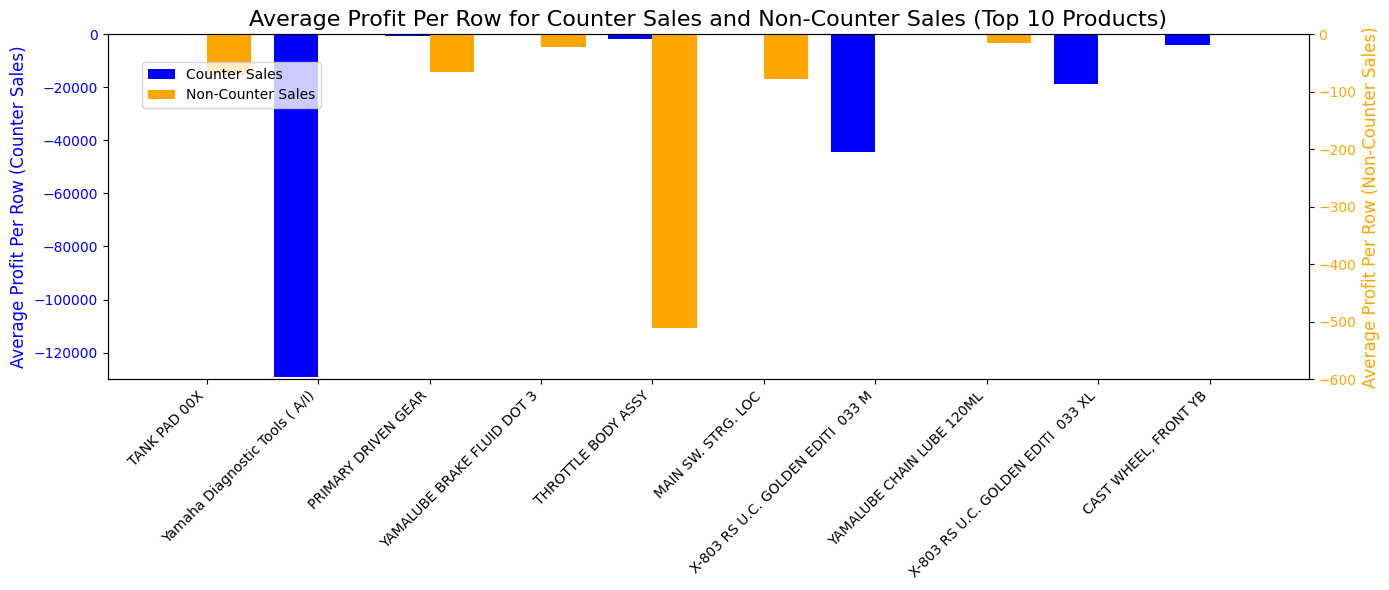


Average Profit Per Row for Counter Sales and Non-Counter Sales (Top 10 Products):
                         Product_Name  Avg_Profit_CounterSales  \
0                        TANK PAD 00X               -77.308672   
1      Yamaha Diagnostic Tools ( A/I)           -129150.000000   
2                 PRIMARY DRIVEN GEAR              -500.069519   
3          YAMALUBE BRAKE FLUID DOT 3               -35.825419   
4                  THROTTLE BODY ASSY             -1728.151515   
5                  MAIN SW. STRG. LOC              -221.154185   
6   X-803 RS U.C. GOLDEN EDITI  033 M            -44380.000000   
7           YAMALUBE CHAIN LUBE 120ML               -14.628417   
8  X-803 RS U.C. GOLDEN EDITI  033 XL            -18630.000000   
9                CAST WHEEL, FRONT YB             -4068.750000   

   Avg_Profit_NonCounterSales  
0                  -70.205132  
1                    0.000000  
2                  -66.026619  
3                  -22.339604  
4                 -510.633333 

In [23]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Calculate profit for all rows
df['Profit'] = df['SellingPrice'] - df['Buying_Price']

# Filter for Counter Sales and non-Counter Sales rows
counter_sales_df = df[df['Job_Card_No'] == 'Counter Sales']
non_counter_sales_df = df[df['Job_Card_No'] != 'Counter Sales']

# Get the top 10 products with the highest loss percentage (as in the previous step)
product_profit = counter_sales_df.groupby('Product_Name')['Profit'].sum().reset_index()
total_profit = product_profit['Profit'].sum()
product_profit['Profit_Percentage'] = (product_profit['Profit'] / total_profit) * 100
top_10_products = product_profit.sort_values('Profit_Percentage').head(10)['Product_Name']

# Calculate average profit per row for Counter Sales and non-Counter Sales
counter_sales_avg_profit = counter_sales_df[counter_sales_df['Product_Name'].isin(top_10_products)] \
    .groupby('Product_Name').apply(lambda x: x['Profit'].sum() / len(x)).reset_index(name='Avg_Profit')

non_counter_sales_avg_profit = non_counter_sales_df[non_counter_sales_df['Product_Name'].isin(top_10_products)] \
    .groupby('Product_Name').apply(lambda x: x['Profit'].sum() / len(x)).reset_index(name='Avg_Profit')

# Ensure both DataFrames have all top 10 products
counter_sales_avg_profit = counter_sales_avg_profit.set_index('Product_Name').reindex(top_10_products).fillna(0).reset_index()
non_counter_sales_avg_profit = non_counter_sales_avg_profit.set_index('Product_Name').reindex(top_10_products).fillna(0).reset_index()

# Merge the results for easy plotting
avg_profit_df = pd.merge(counter_sales_avg_profit, non_counter_sales_avg_profit, on='Product_Name', suffixes=('_CounterSales', '_NonCounterSales'))

# Plotting the results
x = range(len(top_10_products))
width = 0.4  # Width of the bars

fig, ax1 = plt.subplots(figsize=(14, 6))

# Counter Sales bars (left y-axis)
ax1.bar([i - width / 2 for i in x], avg_profit_df['Avg_Profit_CounterSales'], width=width, color='blue', label='Counter Sales')
ax1.set_ylabel('Average Profit Per Row (Counter Sales)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(-130000, 0)  # Set limits for the left y-axis

# Non-Counter Sales bars (right y-axis)
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
ax2.bar([i + width / 2 for i in x], avg_profit_df['Avg_Profit_NonCounterSales'], width=width, color='orange', label='Non-Counter Sales')
ax2.set_ylabel('Average Profit Per Row (Non-Counter Sales)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(-600, 0)  # Set limits for the right y-axis

# Set x-axis labels and title
ax1.set_xticks(x)
ax1.set_xticklabels(avg_profit_df['Product_Name'], rotation=45, ha='right')
plt.title('Average Profit Per Row for Counter Sales and Non-Counter Sales (Top 10 Products)', fontsize=16)
plt.xlabel('Product Name', fontsize=14)

# Add a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()

# Display the results in the terminal
print("\nAverage Profit Per Row for Counter Sales and Non-Counter Sales (Top 10 Products):")
print(avg_profit_df)

3 most sold products per services

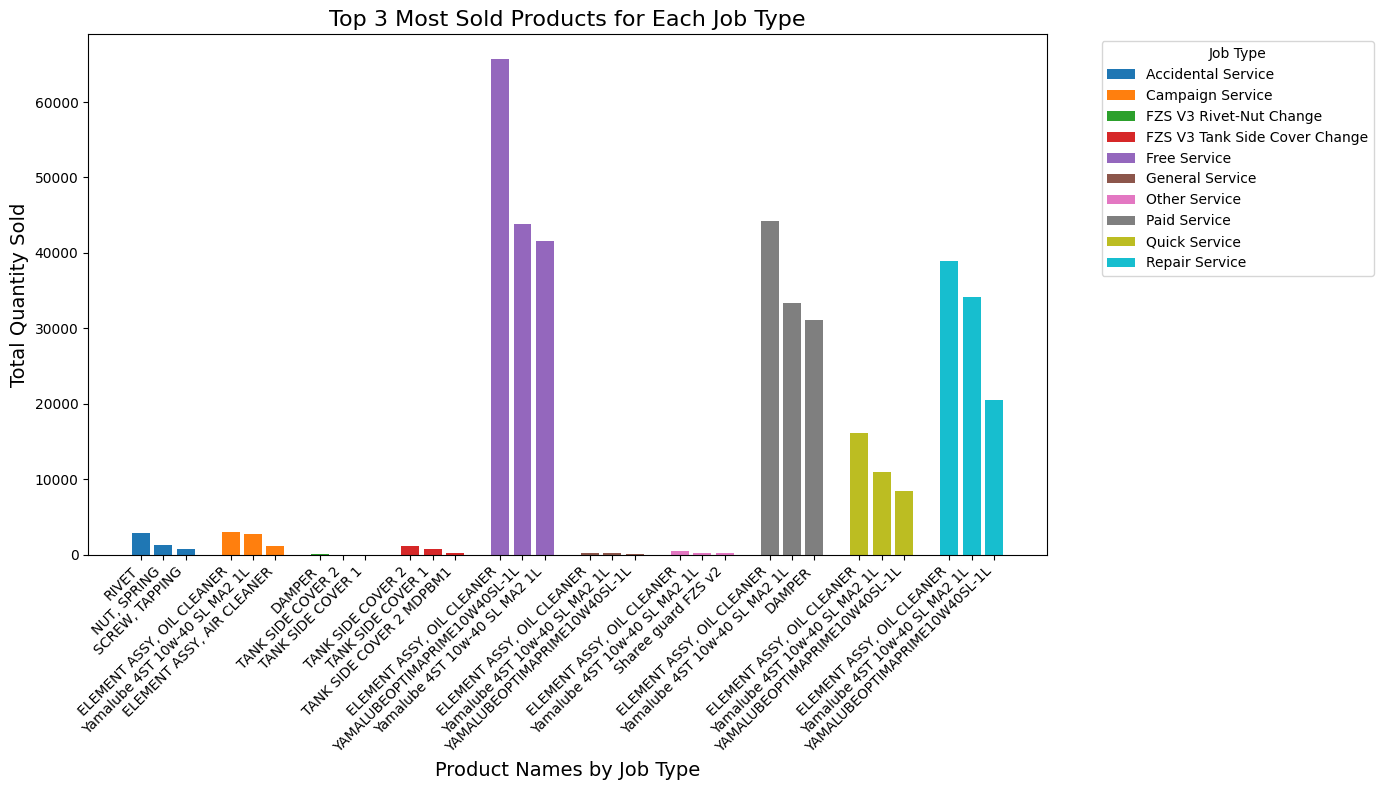

Top 3 Most Sold Products for Each 'Job_Type':
                         Job_Type                   Product_Name  Quantity
0              Accidental Service                          RIVET      2822
1              Accidental Service                    NUT, SPRING      1304
2              Accidental Service                 SCREW, TAPPING       788
3                Campaign Service      ELEMENT ASSY, OIL CLEANER      3030
4                Campaign Service  Yamalube 4ST 10w-40 SL MA2 1L      2750
5                Campaign Service      ELEMENT ASSY, AIR CLEANER      1194
6         FZS V3 Rivet-Nut Change                         DAMPER         6
7         FZS V3 Rivet-Nut Change              TANK SIDE COVER 2         4
8         FZS V3 Rivet-Nut Change              TANK SIDE COVER 1         3
9   FZS V3 Tank Side Cover Change              TANK SIDE COVER 2      1092
10  FZS V3 Tank Side Cover Change              TANK SIDE COVER 1       754
11  FZS V3 Tank Side Cover Change       TANK SIDE COVE

In [24]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Group data by 'Job_Type' and 'Product_Name' to calculate total quantity sold
job_type_product_sales = df.groupby(['Job_Type', 'Product_Name'])['Quantity'].sum().reset_index()

# Get the top 3 products for each 'Job_Type'
top_products_per_job_type = job_type_product_sales.groupby('Job_Type').apply(
    lambda x: x.nlargest(3, 'Quantity')).reset_index(drop=True)

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 8))

# Create a bar for each Job_Type
x_offset = 0  # To position bars for different Job_Types
bar_positions = []  # To store bar positions for custom ticks
bar_labels = []  # To store corresponding Job_Type and Product_Name labels

for idx, job_type in enumerate(top_products_per_job_type['Job_Type'].unique()):
    job_type_data = top_products_per_job_type[top_products_per_job_type['Job_Type'] == job_type]
    x_positions = range(x_offset, x_offset + len(job_type_data))
    bar_positions.extend(x_positions)
    bar_labels.extend(job_type_data['Product_Name'])
    ax.bar(x_positions, job_type_data['Quantity'], label=job_type)
    x_offset += len(job_type_data) + 1  # Add gap between groups

# Formatting the plot
ax.set_title('Top 3 Most Sold Products for Each Job Type', fontsize=16)
ax.set_xlabel('Product Names by Job Type', fontsize=14)
ax.set_ylabel('Total Quantity Sold', fontsize=14)
ax.set_xticks(bar_positions)
ax.set_xticklabels(bar_labels, rotation=45, ha='right', fontsize=10)
ax.legend(title='Job Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display the results in the terminal
print("Top 3 Most Sold Products for Each 'Job_Type':")
print(top_products_per_job_type)

5 customers service time taking

In [25]:
# Ensure the Invoice_Date column is in datetime format
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])

# Input customer names
customers = ["MD.ABDUR RASHID", "MD. NURZZAMAN", "MOHAMMAD AZIZUL HAKIM MOTIN", "MD.ZAHANGIR ALAM", "MD. MANIK UDDIN"]

# Initialize a DataFrame to store all results
results_table = pd.DataFrame()

# Loop through each customer
for customer in customers:
    # Filter data for the specific customer
    customer_data = df[df['Customer_Name'] == customer]
    
    if customer_data.empty:
        continue
    
    # Sort data by Invoice_Date
    customer_data = customer_data.sort_values(by='Invoice_Date')
    
    # Calculate the days between activities
    customer_data['Days_Since_Last_Job'] = customer_data['Invoice_Date'].diff().dt.days
    
    # Add customer name to the DataFrame
    customer_data['Customer_Name'] = customer
    
    # Select relevant columns for the table
    customer_data = customer_data[['Customer_Name', 'Invoice_Date', 'Days_Since_Last_Job', 'Job_Type']]
    
    # Append to results
    results_table = pd.concat([results_table, customer_data])

# Reset index for cleaner table
results_table.reset_index(drop=True, inplace=True)

# Display the results in a well-formatted table
print("\nCustomer Job Type Analysis:")
print(results_table.to_string(index=False))


Customer Job Type Analysis:
              Customer_Name Invoice_Date  Days_Since_Last_Job         Job_Type
            MD.ABDUR RASHID   2024-01-04                  NaN     Paid Service
            MD.ABDUR RASHID   2024-01-18                 14.0   Repair Service
            MD.ABDUR RASHID   2024-02-10                 23.0   Repair Service
            MD.ABDUR RASHID   2024-02-15                  5.0     Free Service
            MD.ABDUR RASHID   2024-02-18                  3.0   Repair Service
            MD.ABDUR RASHID   2024-02-18                  0.0   Repair Service
            MD.ABDUR RASHID   2024-02-18                  0.0   Repair Service
            MD.ABDUR RASHID   2024-02-18                  0.0   Repair Service
            MD.ABDUR RASHID   2024-02-18                  0.0   Repair Service
            MD.ABDUR RASHID   2024-03-04                 15.0   Repair Service
            MD.ABDUR RASHID   2024-03-13                  9.0     Free Service
            MD.ABDUR RA

In [26]:
# Ensure there are no leading or trailing spaces in the column name
df.rename(columns=lambda x: x.strip(), inplace=True)

# Get the unique values in the "Job_Type" column
unique_job_types = df['Job_Type'].unique()

# Display the unique values
print("Unique values in 'Job_Type':")
for job_type in unique_job_types:
    print(job_type)


Unique values in 'Job_Type':
Repair Service
nan
Free Service
Paid Service
Quick Service
FZS V3 Tank Side Cover Change
Other Service
Accidental Service
Campaign Service
General Service
FZS V3 Rivet-Nut Change


Top 50 Products Ranked by Quantity and Discount Percentage

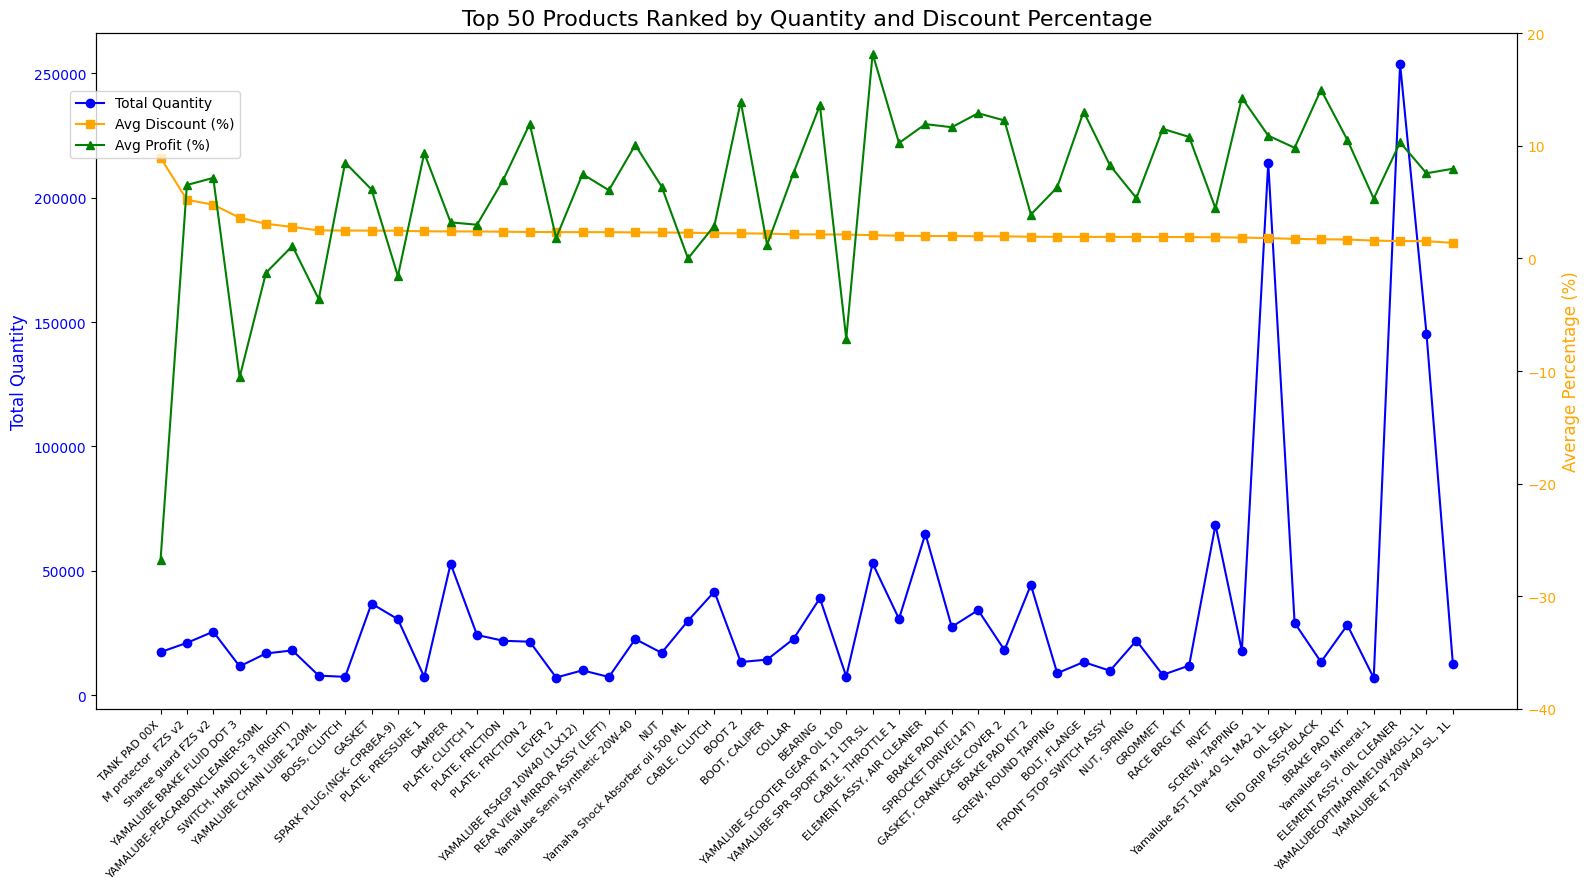


Top 50 Products Ranked by Quantity and Discount Percentage:
                          Product_Name  Total_Quantity  \
2168                      TANK PAD 00X           17266   
1077               M protector  FZS v2           20969   
2163               Sharee guard FZS v2           25481   
2326        YAMALUBE BRAKE FLUID DOT 3           11529   
2339    YAMALUBE-PEACARBONCLEANER-50ML           16710   
2156          SWITCH, HANDLE 3 (RIGHT)           17937   
2330         YAMALUBE CHAIN LUBE 120ML            7789   
151                       BOSS, CLUTCH            7308   
805                             GASKET           36773   
2046        SPARK PLUG,(NGK- CPR8EA-9)           30477   
1790                 PLATE, PRESSURE 1            7223   
607                             DAMPER           52806   
1777                   PLATE, CLUTCH 1           24141   
1783                   PLATE, FRICTION           21803   
1786                 PLATE, FRICTION 2           21451   
1054       

In [27]:
# Ensure correct column names and calculations
df['Discount_Percentage'] = ((df['Discount'] + df['AffiliatorDiscount']) / 
                             (df['Discount'] + df['AffiliatorDiscount'] + df['SellingPrice'])) * 100
df['Profit_Percentage'] = ((df['SellingPrice'] - df['Buying_Price']) / df['Buying_Price']) * 100

# Remove the filter for Discount > 0 to include all discounts
all_discounts = df

# Group by Product_Name and calculate total quantity, average discount percentage, and average profit percentage
product_stats = all_discounts.groupby('Product_Name').agg(
    Total_Quantity=('Quantity', 'sum'),
    Avg_Discount_Percentage=('Discount_Percentage', 'mean'),
    Avg_Profit_Percentage=('Profit_Percentage', 'mean')
).reset_index()

# Step 1: Rank by Total Quantity (Top 50 products)
top_50_products = product_stats.nlargest(50, 'Total_Quantity')

# Step 2: Rank the selected products by Avg Discount Percentage (High to Low)
ranked_products = top_50_products.sort_values(by='Avg_Discount_Percentage', ascending=False)

# Plotting
fig, ax1 = plt.subplots(figsize=(16, 9))

# Line for total quantity (left y-axis)
ax1.plot(ranked_products['Product_Name'], ranked_products['Total_Quantity'], color='blue', marker='o', label='Total Quantity')
ax1.set_ylabel('Total Quantity', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(len(ranked_products['Product_Name'])))
ax1.set_xticklabels(ranked_products['Product_Name'], rotation=45, ha='right', fontsize=8)

# Line for average discount percentage (right y-axis)
ax2 = ax1.twinx()
ax2.plot(ranked_products['Product_Name'], ranked_products['Avg_Discount_Percentage'], color='orange', marker='s', label='Avg Discount (%)')
ax2.plot(ranked_products['Product_Name'], ranked_products['Avg_Profit_Percentage'], color='green', marker='^', label='Avg Profit (%)')
ax2.set_ylabel('Average Percentage (%)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(-40, 20)  # Set the range for percentage axes

# Title and layout
plt.title('Top 50 Products Ranked by Quantity and Discount Percentage', fontsize=16)
fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.1, 0.9), fontsize=10)
plt.show()

# Display results in the terminal
print("\nTop 50 Products Ranked by Quantity and Discount Percentage:")
print(ranked_products)

Ranked Product Codes with All Rows Having Discount Greater Than 0 (Sorted by Row Count

In [28]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Group by Product_Code and calculate total rows and rows with Discount > 0
discount_analysis = df.groupby('Product_Code').apply(
    lambda x: pd.Series({
        'Total_Rows': len(x),
        'Discount_Rows': (x['Discount'] > 0).sum(),
        'Discount_Percentage': (x['Discount'] > 0).sum() / len(x) * 100
    })
).reset_index()

# Sort the table by Discount_Percentage in descending order
discount_analysis = discount_analysis.sort_values(by='Discount_Percentage', ascending=False).reset_index(drop=True)

# Display the entire table
print("Product Code Discount Analysis (Sorted by Discount Percentage):")
print(discount_analysis)

# Reset pandas display options to default after displaying the table
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


Product Code Discount Analysis (Sorted by Discount Percentage):
     Product_Code  Total_Rows  Discount_Rows  Discount_Percentage
0            PCUW         1.0            1.0           100.000000
1            YJ99         1.0            1.0           100.000000
2            PCTK         1.0            1.0           100.000000
3            YK19         1.0            1.0           100.000000
4            PZ13         1.0            1.0           100.000000
5            P938         1.0            1.0           100.000000
6            PZ18         1.0            1.0           100.000000
7            PZ20         1.0            1.0           100.000000
8            PZ21         1.0            1.0           100.000000
9            P929         1.0            1.0           100.000000
10           P930         1.0            1.0           100.000000
11           PY41         1.0            1.0           100.000000
12           PY91         1.0            1.0           100.000000
13          

Cluster Center Analysis of Discount vs Profit for Multiple Product Codes (Subplots for Each Product Code)

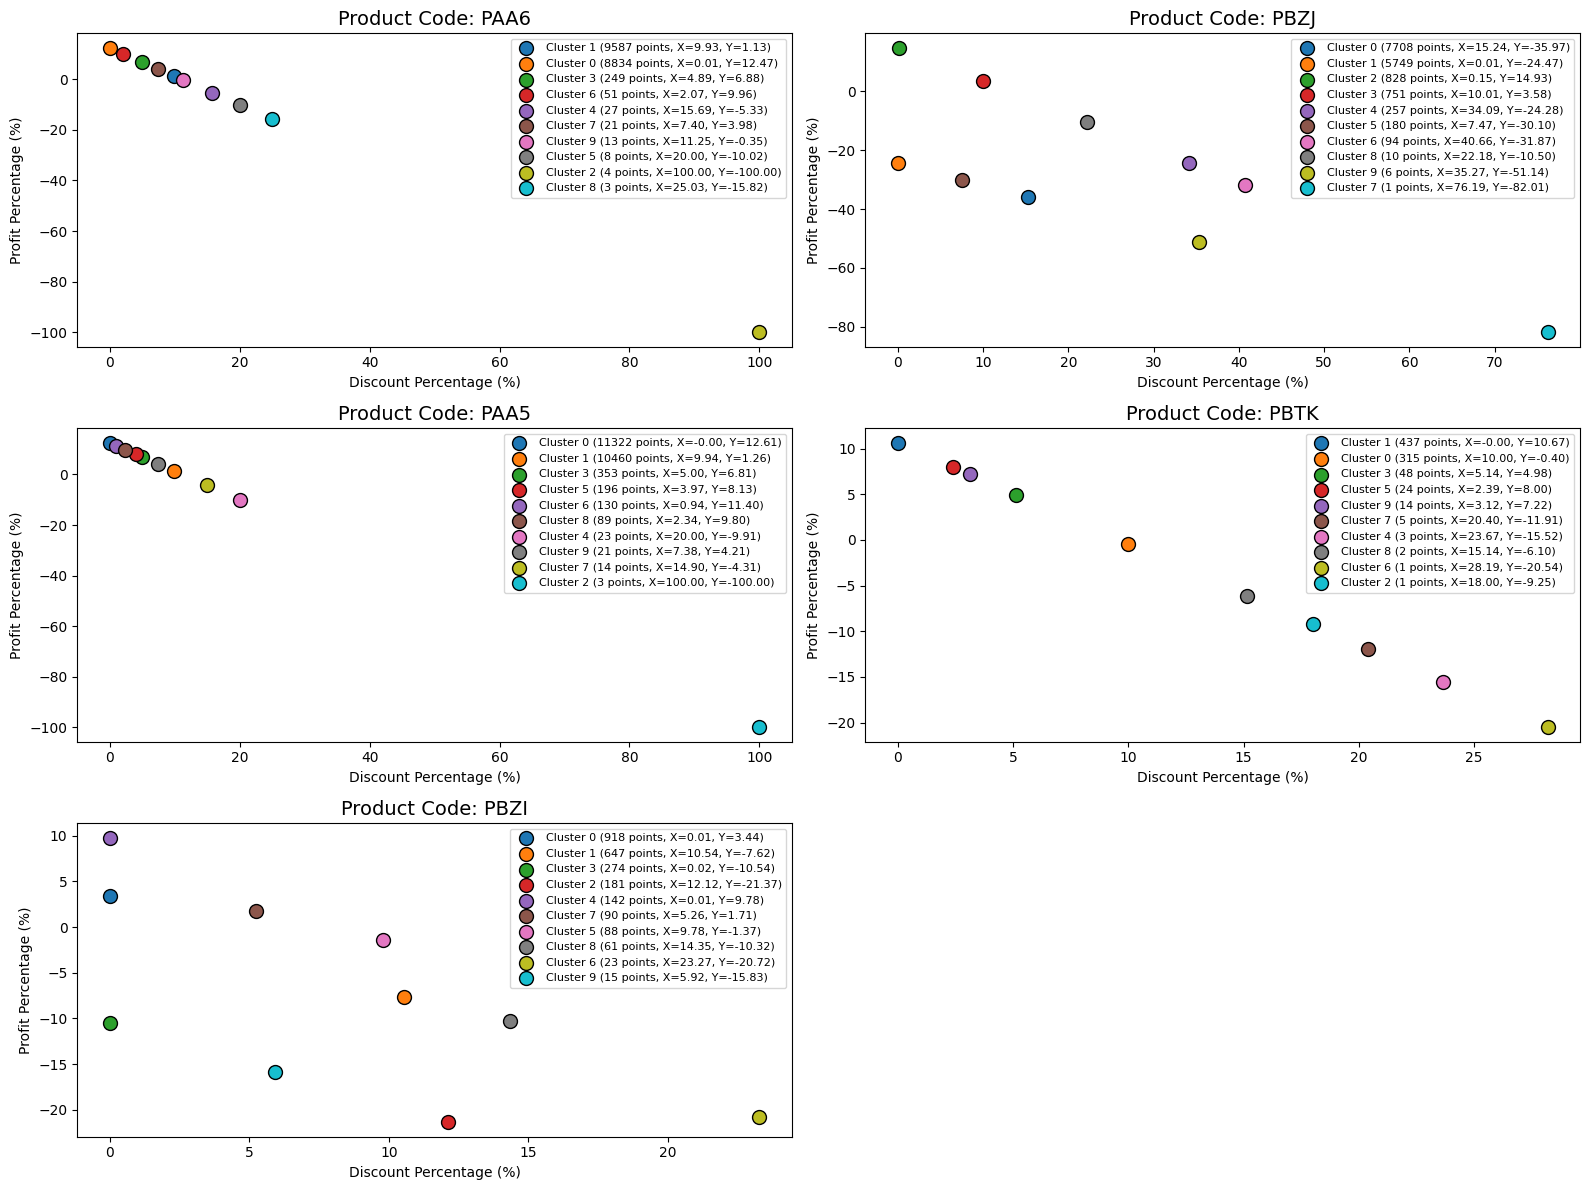

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Add discount and profit percentages using apply
df['Discount_Percentage'] = df.apply(
    lambda row: ((row['Discount'] + row['AffiliatorDiscount']) / 
                 (row['Discount'] + row['AffiliatorDiscount'] + row['SellingPrice'])) * 100 
    if (row['Discount'] + row['AffiliatorDiscount'] + row['SellingPrice']) != 0 else 0, axis=1)

df['Profit_Percentage'] = df.apply(
    lambda row: ((row['SellingPrice'] - row['Buying_Price']) / row['Buying_Price']) * 100 
    if row['Buying_Price'] != 0 else 0, axis=1)

# Predefined product codes and cluster number
product_codes = ['PAA6', 'PBZJ', 'PAA5', 'PBTK', 'PBZI']
n_clusters = 10

# Function to perform clustering and plot
def analyze_product_clustering(product_code, n_clusters, ax):
    # Filter data for the specific product code
    product_data = df[df['Product_Code'] == product_code][['Discount_Percentage', 'Profit_Percentage']].dropna()
    
    if product_data.empty:
        ax.set_title(f"No data for Product Code: {product_code}", fontsize=12)
        return

    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(product_data)

    # Apply K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    product_data['Cluster'] = kmeans.fit_predict(scaled_data)

    # Count points in each cluster and rank them
    cluster_counts = product_data['Cluster'].value_counts().sort_values(ascending=False)
    ranked_clusters = cluster_counts.index.tolist()

    # Get cluster centers and scale back to original values
    centers = scaler.inverse_transform(kmeans.cluster_centers_)

    # Plot only cluster centers
    for rank, cluster_id in enumerate(ranked_clusters):
        center = centers[cluster_id]
        cluster_size = cluster_counts[cluster_id]
        ax.scatter(
            center[0], center[1], 
            label=f'Cluster {cluster_id} ({cluster_size} points, X={center[0]:.2f}, Y={center[1]:.2f})', 
            s=100, edgecolor='black'
        )

    # Format subplot
    ax.set_title(f'Product Code: {product_code}', fontsize=14)
    ax.set_xlabel('Discount Percentage (%)', fontsize=10)
    ax.set_ylabel('Profit Percentage (%)', fontsize=10)
    ax.legend(fontsize=8, loc='best')

# Create subplots for all product codes
fig, axes = plt.subplots(3, 2, figsize=(16, 12))  # Adjust layout for 5 subplots
axes = axes.flatten()

for idx, product_code in enumerate(product_codes):
    analyze_product_clustering(product_code, n_clusters, axes[idx])

# Remove unused subplot if any
for i in range(len(product_codes), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [30]:
# Predefined product codes
product_codes = ['PAA6', 'PBZJ', 'PAA5', 'PBTK', 'PBZI']

# Dictionary to store top 5 dealers for each product code
top_dealers = {}

# Loop through each product code to find top 5 dealers
for product_code in product_codes:
    # Filter data for the specific product code
    product_data = df[df['Product_Code'] == product_code]
    
    if product_data.empty:
        print(f"No data found for Product Code: {product_code}")
        continue

    # Group by Dealer_Code and sum the Quantity
    dealer_sales = product_data.groupby('Dealer_Code')['Quantity'].sum().reset_index()

    # Sort by Quantity in descending order and get the top 5
    top_5 = dealer_sales.sort_values(by='Quantity', ascending=False).head(5)

    # Store the result
    top_dealers[product_code] = top_5

# Display the results
for product_code, dealers in top_dealers.items():
    print(f"\nTop 5 Dealers for Product Code: {product_code}")
    print(dealers)



Top 5 Dealers for Product Code: PAA6
   Dealer_Code  Quantity
30      HC005G      1175
17      HC0029       603
14      HC0016       513
24      HC0050       428
0       HC0002       423

Top 5 Dealers for Product Code: PBZJ
   Dealer_Code  Quantity
26      HC005G       725
14      HC0016       598
21      HC0050       485
1       HC0003       451
17      HC002G       450

Top 5 Dealers for Product Code: PAA5
   Dealer_Code  Quantity
30      HC005G       890
0       HC0002       734
17      HC0029       619
14      HC0016       610
9       HC000L       532

Top 5 Dealers for Product Code: PBTK
   Dealer_Code  Quantity
21      HC0058       123
24      HC005G        97
20      HC004T        93
16      HC002G        41
6       HC000G        40

Top 5 Dealers for Product Code: PBZI
   Dealer_Code  Quantity
1       HC0003       325
22      HC005G       229
45      HC008U       211
75      HC00E5        94
53      HC00A4        91


Average Discount Percentage Over 7-Day Intervals for Top 5 Dealers (Per Product Code) (the average discout percentage over 50% was excluded)

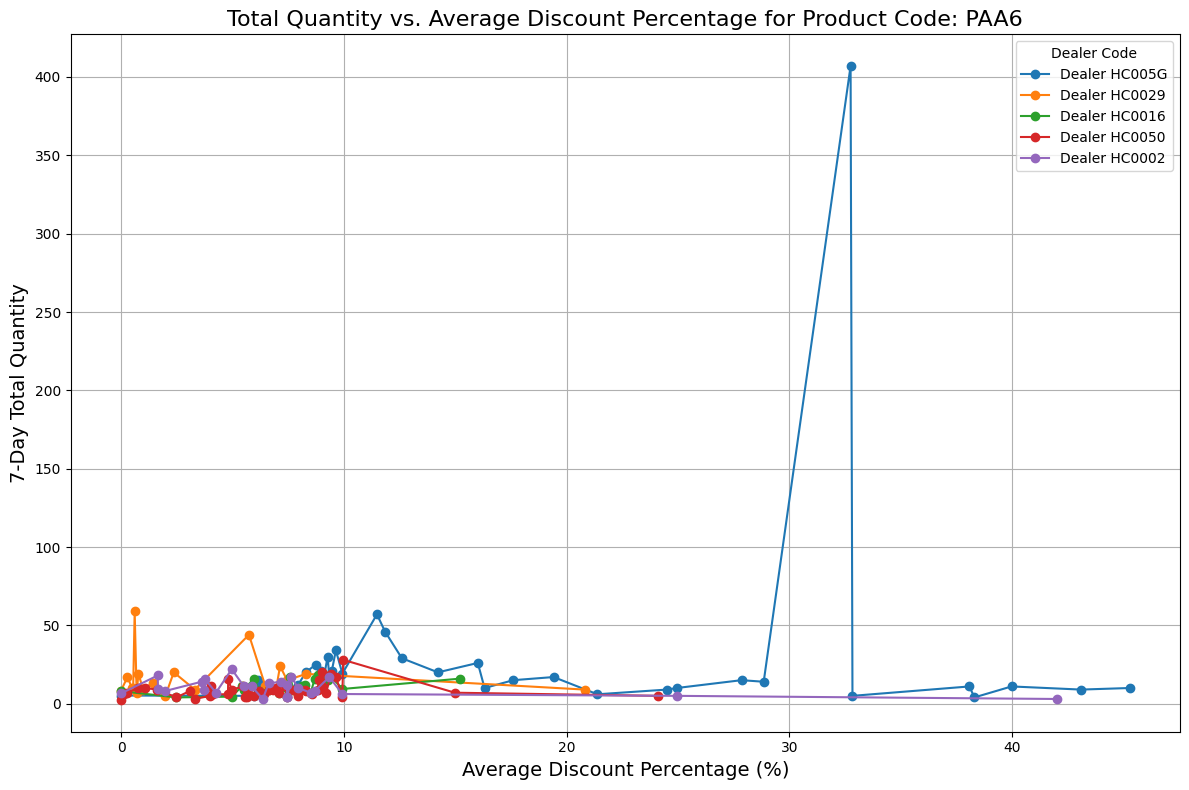

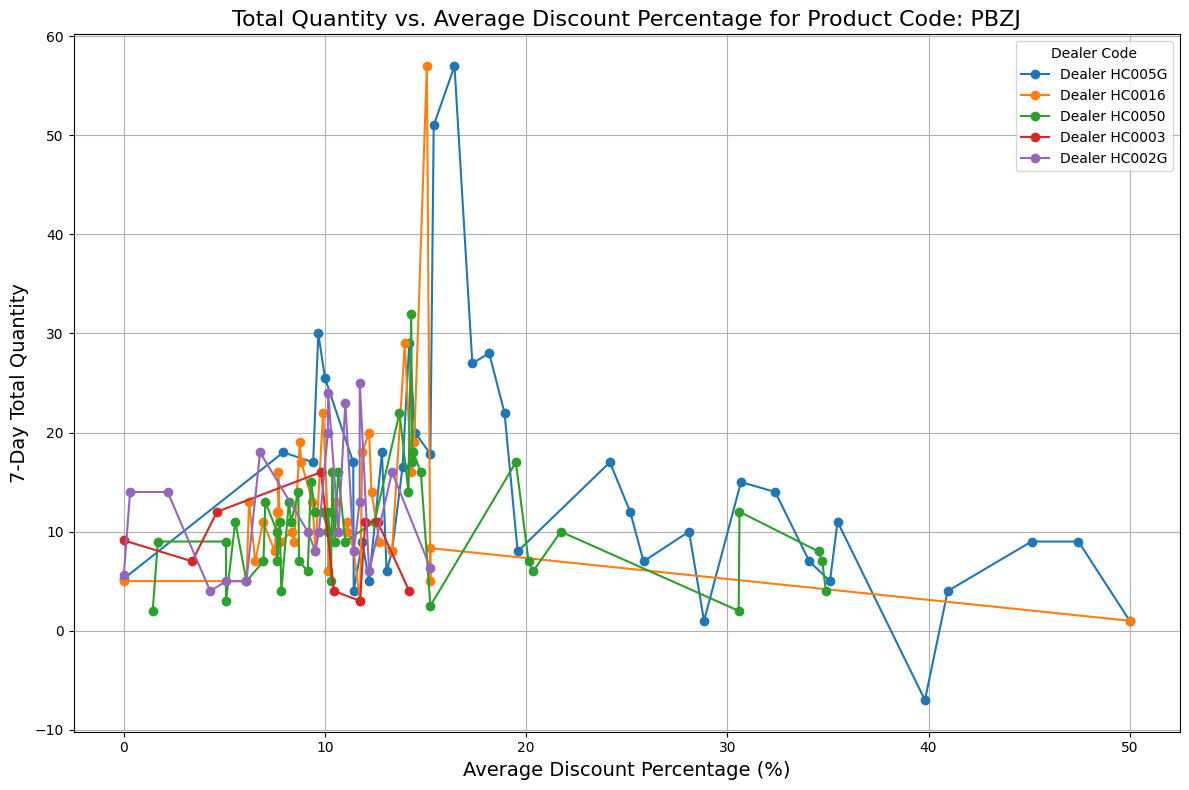

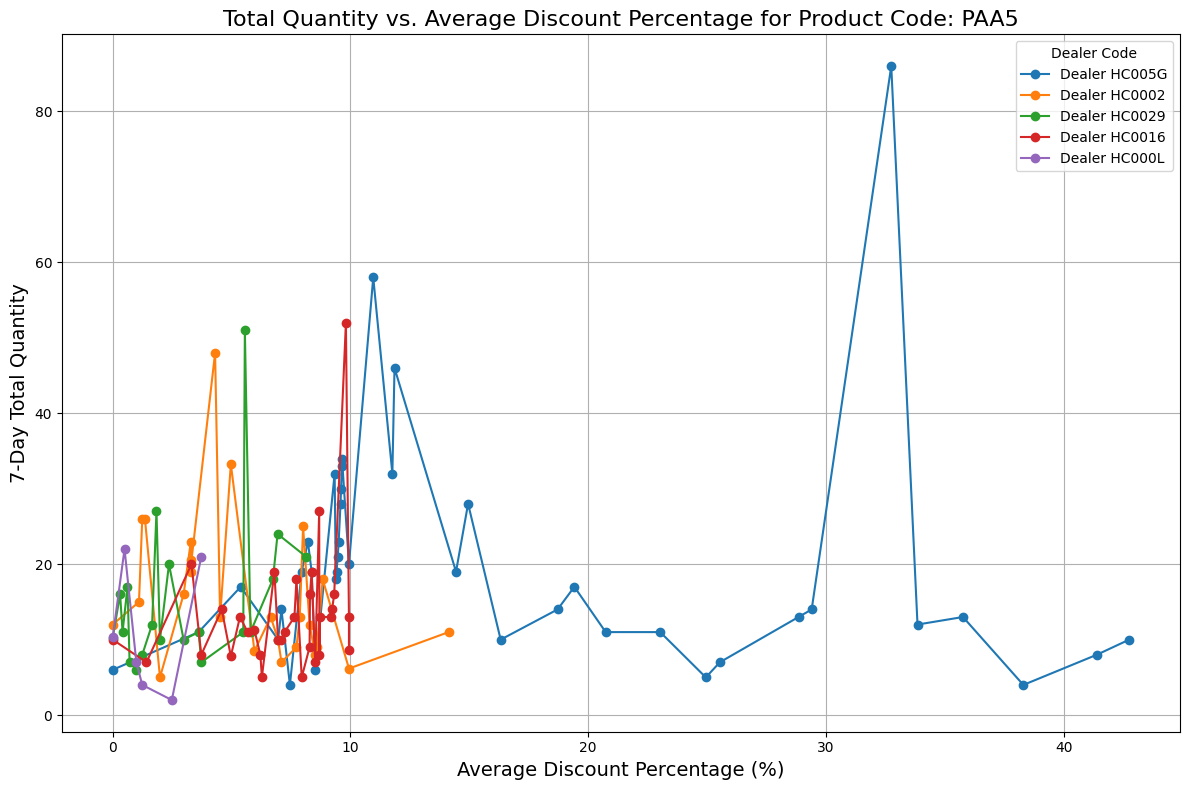

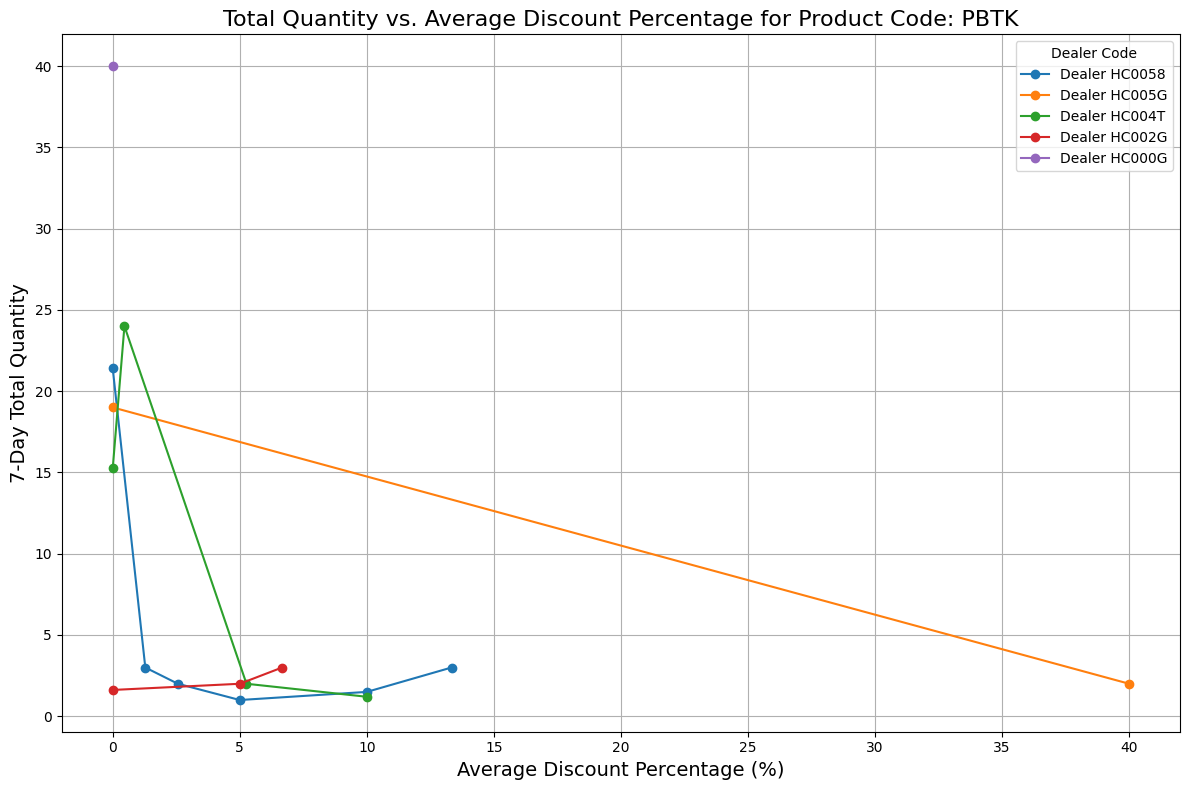

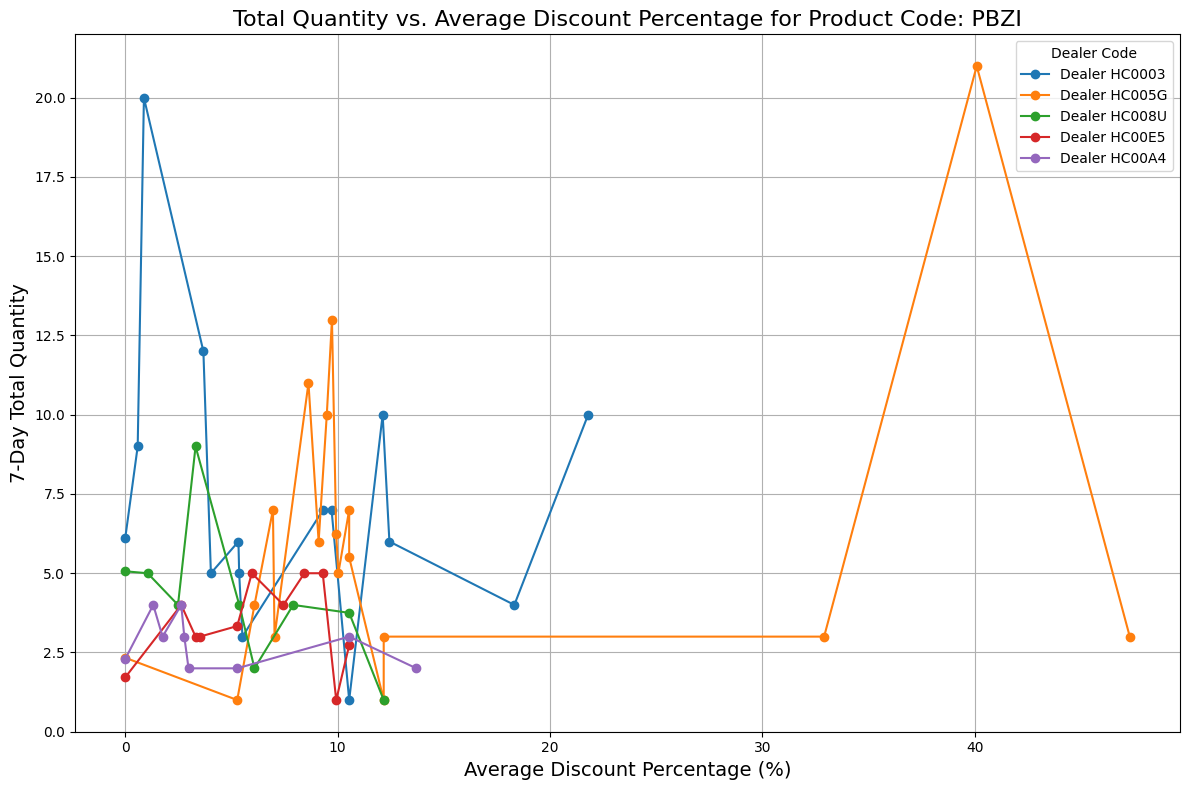

In [31]:
# Predefined product codes
product_codes = ['PAA6', 'PBZJ', 'PAA5', 'PBTK', 'PBZI']

# Calculate Discount Percentage
df['Discount_Percentage'] = df.apply(
    lambda row: ((row['Discount'] + row['AffiliatorDiscount']) /
                 (row['Discount'] + row['AffiliatorDiscount'] + row['SellingPriceTotal'])) * 100 
    if (row['Discount'] + row['AffiliatorDiscount'] + row['SellingPriceTotal']) > 0 else 0, axis=1)

# Function to calculate 7-day interval statistics
def calculate_7_day_stats(data):
    # Ensure Invoice_Date is in datetime format
    data['Invoice_Date'] = pd.to_datetime(data['Invoice_Date'])

    # Create a column for 7-day intervals
    data['7_Day_Interval'] = (data['Invoice_Date'].dt.dayofyear // 7) + 1

    # Group by Dealer_Code and 7-Day Interval to calculate total quantity and average discount percentage
    grouped = data.groupby(['Dealer_Code', '7_Day_Interval']).agg(
        Total_Quantity=('Quantity', 'sum'),
        Avg_Discount_Percentage=('Discount_Percentage', 'mean')
    ).reset_index()

    return grouped

# Loop through each product code and create a plot
for product_code in product_codes:
    # Filter data for the specific product code
    product_data = df[df['Product_Code'] == product_code]

    if product_data.empty:
        print(f"No data found for Product Code: {product_code}")
        continue

    # Group data for 7-day intervals
    interval_data = calculate_7_day_stats(product_data)

    # Exclude rows where Avg_Discount_Percentage > 50%
    interval_data = interval_data[interval_data['Avg_Discount_Percentage'] <= 50]

    # Average Total_Quantity for the same Avg_Discount_Percentage
    aggregated_data = interval_data.groupby(['Dealer_Code', 'Avg_Discount_Percentage']).agg(
        Avg_Total_Quantity=('Total_Quantity', 'mean')
    ).reset_index()

    # Get the top 5 dealers for the product code based on total quantity
    top_5_dealers = product_data.groupby('Dealer_Code')['Quantity'].sum().nlargest(5).index.tolist()

    # Plotting
    plt.figure(figsize=(12, 8))
    for dealer in top_5_dealers:
        dealer_data = aggregated_data[aggregated_data['Dealer_Code'] == dealer]
        plt.plot(
            dealer_data['Avg_Discount_Percentage'], dealer_data['Avg_Total_Quantity'],
            label=f"Dealer {dealer}", marker='o'  # Add circle markers
        )

    # Format the plot
    plt.title(f'Total Quantity vs. Average Discount Percentage for Product Code: {product_code}', fontsize=16)
    plt.xlabel('Average Discount Percentage (%)', fontsize=14)
    plt.ylabel('7-Day Total Quantity', fontsize=14)
    plt.legend(title="Dealer Code", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Best Fit Line for Total Quantity vs. Average Discount Percentage for Top 5 Dealers (Per Product Code)

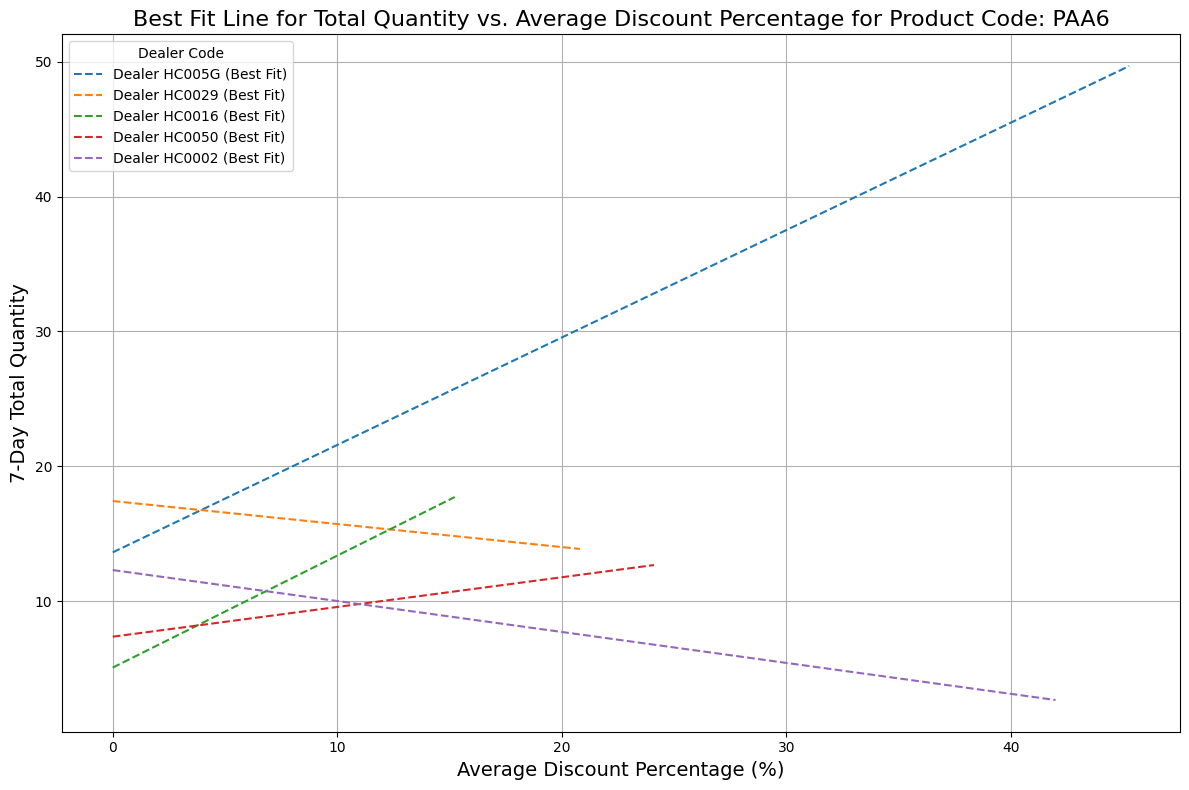

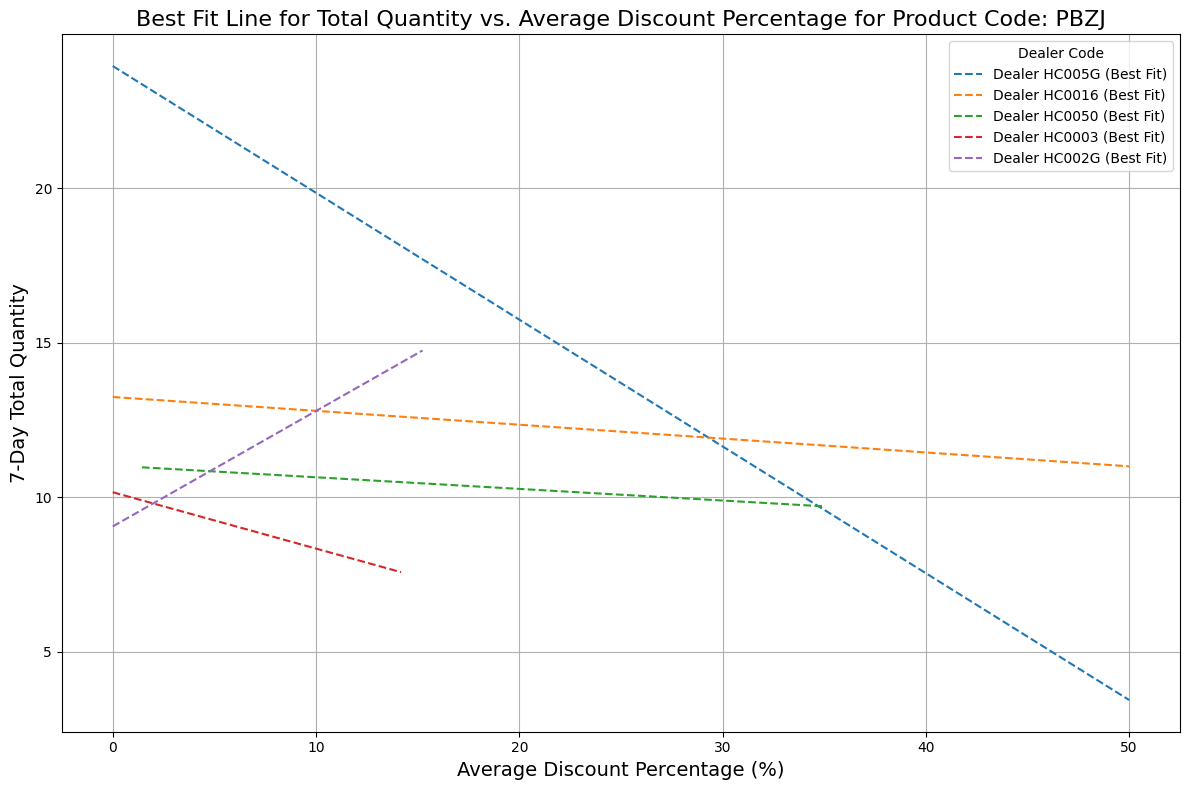

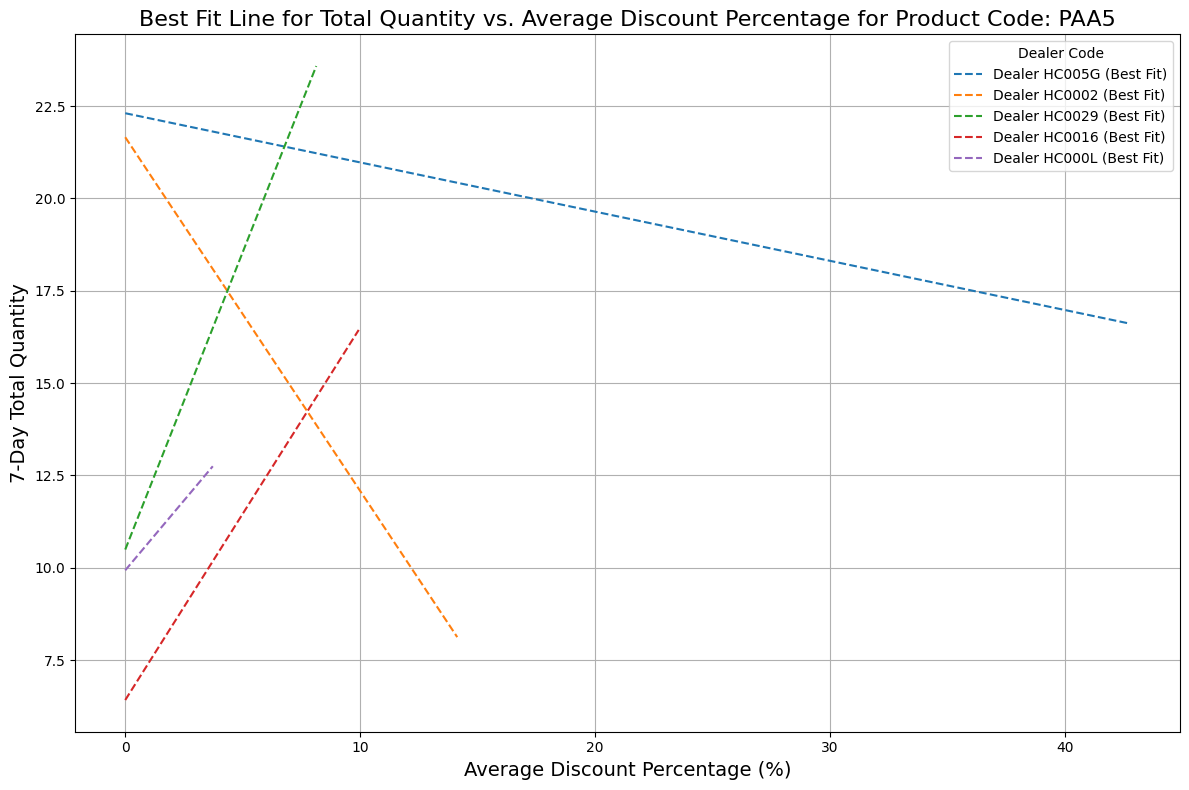

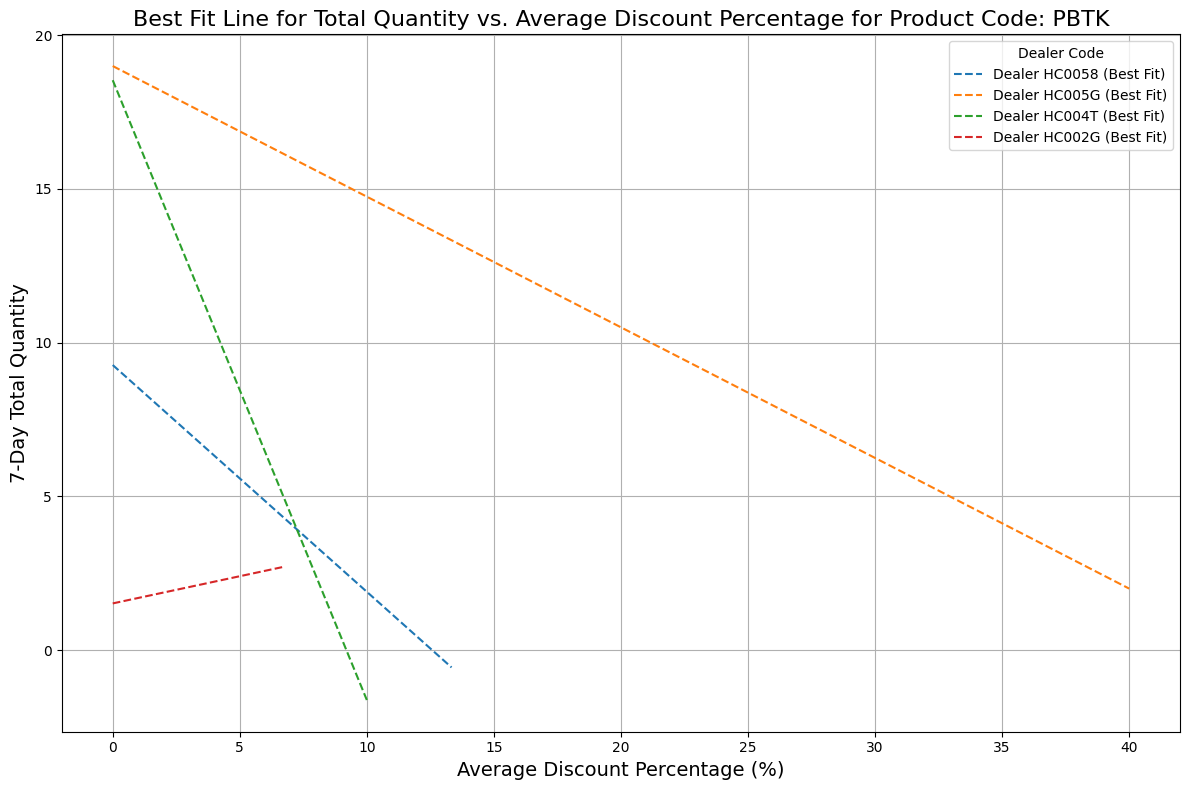

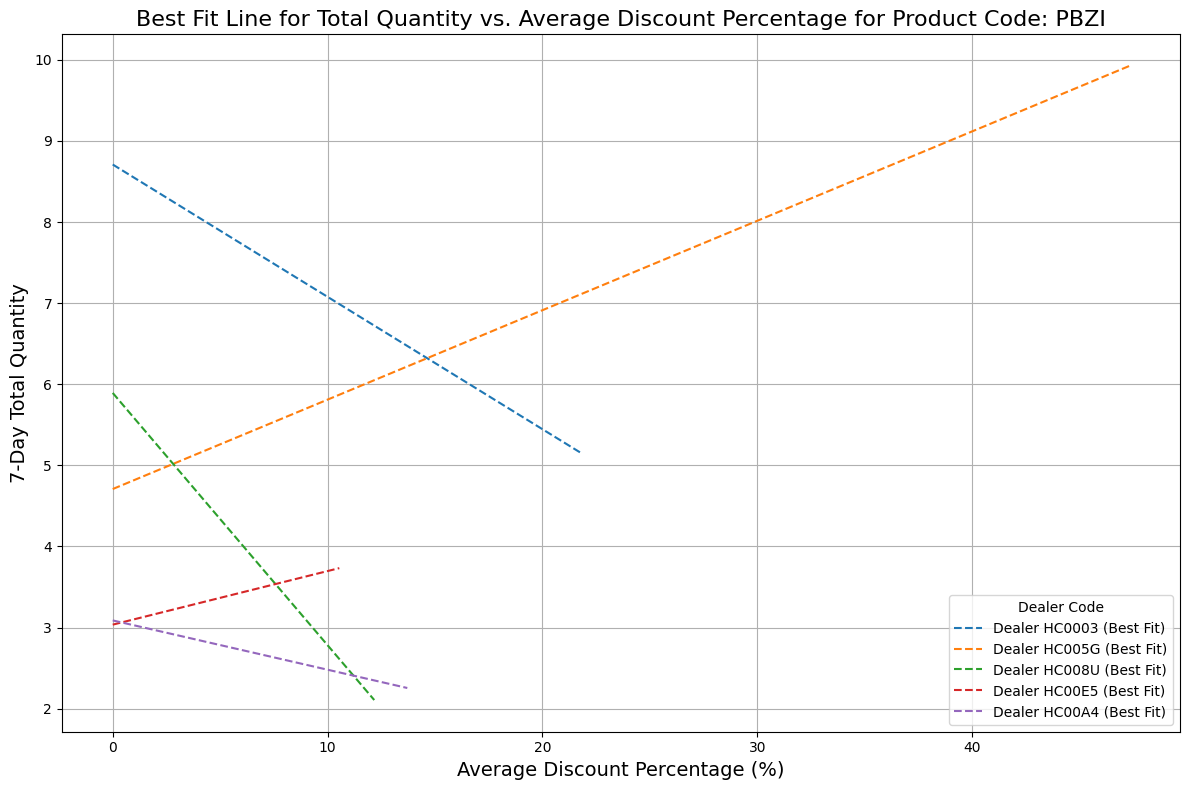

In [32]:
# Predefined product codes
product_codes = ['PAA6', 'PBZJ', 'PAA5', 'PBTK', 'PBZI']

# Calculate Discount Percentage
df['Discount_Percentage'] = df.apply(
    lambda row: ((row['Discount'] + row['AffiliatorDiscount']) /
                 (row['Discount'] + row['AffiliatorDiscount'] + row['SellingPriceTotal'])) * 100 
    if (row['Discount'] + row['AffiliatorDiscount'] + row['SellingPriceTotal']) > 0 else 0, axis=1)

# Function to calculate 7-day interval statistics
def calculate_7_day_stats(data):
    # Ensure Invoice_Date is in datetime format
    data['Invoice_Date'] = pd.to_datetime(data['Invoice_Date'])

    # Create a column for 7-day intervals
    data['7_Day_Interval'] = (data['Invoice_Date'].dt.dayofyear // 7) + 1

    # Group by Dealer_Code and 7-Day Interval to calculate total quantity and average discount percentage
    grouped = data.groupby(['Dealer_Code', '7_Day_Interval']).agg(
        Total_Quantity=('Quantity', 'sum'),
        Avg_Discount_Percentage=('Discount_Percentage', 'mean')
    ).reset_index()

    return grouped

# Loop through each product code and create a plot
for product_code in product_codes:
    # Filter data for the specific product code
    product_data = df[df['Product_Code'] == product_code]

    if product_data.empty:
        print(f"No data found for Product Code: {product_code}")
        continue

    # Group data for 7-day intervals
    interval_data = calculate_7_day_stats(product_data)

    # Exclude rows where Avg_Discount_Percentage > 50%
    interval_data = interval_data[interval_data['Avg_Discount_Percentage'] <= 50]

    # Average Total_Quantity for the same Avg_Discount_Percentage
    aggregated_data = interval_data.groupby(['Dealer_Code', 'Avg_Discount_Percentage']).agg(
        Avg_Total_Quantity=('Total_Quantity', 'mean')
    ).reset_index()

    # Get the top 5 dealers for the product code based on total quantity
    top_5_dealers = product_data.groupby('Dealer_Code')['Quantity'].sum().nlargest(5).index.tolist()

    # Plotting
    plt.figure(figsize=(12, 8))
    for dealer in top_5_dealers:
        dealer_data = aggregated_data[aggregated_data['Dealer_Code'] == dealer]
        if dealer_data.empty or len(dealer_data) < 2:  # Ensure enough points for fitting
            continue

        # Fit a polynomial of degree 1 (best fit line)
        x = dealer_data['Avg_Discount_Percentage']
        y = dealer_data['Avg_Total_Quantity']
        coefficients = np.polyfit(x, y, 1)
        best_fit_line = np.polyval(coefficients, x)

        # Plot the best fit line
        plt.plot(
            x, best_fit_line, label=f"Dealer {dealer} (Best Fit)", linestyle='--'
        )

    # Format the plot
    plt.title(f'Best Fit Line for Total Quantity vs. Average Discount Percentage for Product Code: {product_code}', fontsize=16)
    plt.xlabel('Average Discount Percentage (%)', fontsize=14)
    plt.ylabel('7-Day Total Quantity', fontsize=14)
    plt.legend(title="Dealer Code", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Top Product Bundling Analysis: Identifying Co-Occurring Products for Best-Selling Items

In [33]:
# Define the top 5 products for which you want to find bundles
top_products = ['ELEMENT ASSY, OIL CLEANER', 
                'Yamalube 4ST 10w-40 SL MA2 1L', 
                'YAMALUBEOPTIMAPRIME10W40SL-1L', 
                'GASKET', 
                'END GRIP ASSY-BLACK']

# Function to find most sold products frequently appearing with a target product
def find_bundle_products(target_product, df, top_n=10):
    # Filter invoices containing the target product
    invoices_with_target = df[df['Product_Name'] == target_product]['InvoiceNo'].unique()
    
    # Filter rows for these invoices
    bundle_data = df[df['InvoiceNo'].isin(invoices_with_target)]
    
    # Exclude the target product itself
    bundle_data = bundle_data[bundle_data['Product_Name'] != target_product]
    
    # Group by Product_Name and count total quantity
    product_counts = bundle_data.groupby('Product_Name')['Quantity'].sum().reset_index()
    
    # Sort by quantity in descending order and select the top N products
    top_bundle_products = product_counts.sort_values(by='Quantity', ascending=False).head(top_n)
    
    return top_bundle_products

# Find bundles for each top product
for product in top_products:
    print(f"\nTop 10 products frequently sold with '{product}':")
    bundles = find_bundle_products(product, df)
    print(bundles)



Top 10 products frequently sold with 'ELEMENT ASSY, OIL CLEANER':
                         Product_Name  Quantity
1871    Yamalube 4ST 10w-40 SL MA2 1L    119423
1864    YAMALUBEOPTIMAPRIME10W40SL-1L     84742
1860  YAMALUBE SPR SPORT 4T,1 LTR,SL      37904
557         ELEMENT ASSY, AIR CLEANER     31448
1495                            RIVET     27205
514                            DAMPER     26172
676                            GASKET     21323
191                     CABLE, CLUTCH     19879
158                   BRAKE PAD KIT 2     19326
1377                  PLATE, CLUTCH 1     18547

Top 10 products frequently sold with 'Yamalube 4ST 10w-40 SL MA2 1L':
                       Product_Name  Quantity
533       ELEMENT ASSY, OIL CLEANER    115225
1768  YAMALUBEOPTIMAPRIME10W40SL-1L     25458
531       ELEMENT ASSY, AIR CLEANER     22840
1407                          RIVET     21604
489                          DAMPER     17154
646                          GASKET     15800
146         